In [1]:
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

pd.options.mode.chained_assignment = None

## Functions

In [2]:
def sum_dict(results:dict)->list:
    return list(map(sum, zip(*results.values())))

In [3]:
def normalize_col(column):
    return (column - column.min()) / (column.max()-column.min())

In [4]:
def df_basing(df:pd.DataFrame)->(pd.DataFrame,pd.DataFrame):
    base_df = df.iloc[:,0].fillna(method='ffill')
    diff_df = df.iloc[:,1:]
    for col in diff_df.columns:
        diff_df.loc[:,col] = diff_df.loc[:,col].div(base_df, axis=0)
    diff_df=diff_df.apply(lambda x: x-1)
    return base_df, diff_df

In [5]:
def base_plot(tickers:list, diff_df):
    fig, ax = plt.subplots(1,1,figsize = (20,10))
    ax.axhline(0 ,color="r", label = tickers[0])
    ax.plot(diff_df,label=diff_df.columns)
    ax.set_title("Difference of European Traded Stocks Versus NYSE Traded Stock")
    ax.set_xlabel("Date")
    ax.set_ylabel(f"Percentage difference to {test_tickers[0]}")
    ax.legend()

In [6]:
def extract_trading_days(df):
    filled_df = df.fillna(method='ffill')
    return [group[1].between_time("14:30","16:30") for group in filled_df.groupby(filled_df.index.day)]

In [7]:
def get_price_data(dates, tickers:list):
    dates = dates.values.flatten().tolist()
    start, end = datetime.utcfromtimestamp(dates[0]/1e9),datetime.utcfromtimestamp(dates[1]/1e9)
    
    data = [yf.Ticker(ticker).history(interval='5m', start=start, end=end)["Close"] for ticker in tickers]
    eur_usd = yf.Ticker('EUR=X').history(interval='5m', start=start, end=end)["Close"]
    
    price_df = pd.concat(data, axis=1, ignore_index=False) #price data
    price_df.columns = tickers
    eur_usd=eur_usd.reindex(price_df.index).fillna(method='ffill')
    
    dfs_to_convert = [ticker for ticker in tickers if "." in ticker]
    price_df.loc[:,dfs_to_convert] = price_df.loc[:,dfs_to_convert].multiply(eur_usd.loc[price_df.index], axis=0)
    
    return_df = pd.concat(data, axis=1, ignore_index=False) #price data
    return_df.columns = tickers
    for col in return_df.columns:
        return_df[col] = normalize_col(return_df[col])
    return price_df, return_df

In [8]:
def trade(traders:list, time_blocks, tickers:list)->list:
    total_history = []
    for i in tqdm(range(len(time_blocks))): # time block: each week
        t1,t2 = get_price_data(time_blocks.loc[i], tickers) # price df, return df
        trading_days_returns = extract_trading_days(t2)
        trading_days_price = extract_trading_days(t1)
        
        bal_history = []
        for td_return, td_price in zip(trading_days_returns,trading_days_price): # trading day: each day
            base_df, diff_df = df_basing(td_return)
            for idx in diff_df.index: # time: each timeframe (5m)
                price_data = td_price.loc[idx].values.flatten().tolist()
                return_data = diff_df.loc[idx].values.flatten().tolist()
                
                td_his = []
                for i,trader in enumerate(traders):
                    trader.data_feed(idx.time(), return_data, price_data, tickers)
                    td_his.append([idx.to_pydatetime(),trader.balance])
                bal_history.append(td_his)
        total_history.append(bal_history)
    return sum(total_history,[])

In [9]:
def download_data(time_blocks, tickers:list)
    for i in range(len(time_blocks)):

SyntaxError: expected ':' (2030268070.py, line 1)

## Get company tickers

In [10]:
companies = pd.read_excel("Stocks.xlsx")

In [11]:
company_names = companies.iloc[:,0]

In [12]:
us_tickers = companies.iloc[:,2:5]
non_us_tickers = companies.iloc[:,5:]
eu_tickers = non_us_tickers.drop(["NEO","BUE","SGO","LSE","IOB","SAO","STO","JPX","HKG","KSC","MEX"], axis = 1)

In [13]:
arb_df = us_tickers.join(eu_tickers).set_index(company_names.values).drop("Fujitsu")
display(arb_df)

,NMS,NMS2,NYQ,GER,FRA,BER,DUS,ISE,MIL,VIE,VIE2
Ryanair,RYAAY,NaN,NaN,RY4C.DE,RY4C.F,RY4D.BE,RY4D.DU,RYA.IR,NaN,NaN,NaN
Tesla,TSLA,NaN,NaN,TL0.DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Netflix,NFLX,NaN,NaN,NFC.DE,NaN,NaN,NaN,NaN,NFLX.MI,NaN,NaN
Google,GOOG,GOOGL,NaN,ABEA.DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Berkshire Hathaway,BRK-B,BRK-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRKB.VI,BRKA.VI
Amazon,AMZN,NaN,NaN,AMZ.DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Walmart,WMT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Apple,AAPL,NaN,NaN,APC.DE,APC.F,NaN,NaN,NaN,NaN,NaN,NaN
Microsoft,MSFT,NaN,NaN,MSF.DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
General Motors,NaN,NaN,GM,8GM.DE,8GM.F,NaN,NaN,NaN,NaN,GMOT.VI,NaN


## Get Price Data

In [14]:
starts = pd.bdate_range('2022-12-01', '2023-01-20', freq="7B").to_frame(index=False)
stops = pd.bdate_range('2022-12-08', '2023-01-27', freq="7B").to_frame(index=False)
time_blocks = pd.concat([starts,stops], axis = 1)

display(time_blocks)

,0,0
0,2022-12-01,2022-12-08
1,2022-12-12,2022-12-19
2,2022-12-21,2022-12-28
3,2022-12-30,2023-01-06
4,2023-01-10,2023-01-17
5,2023-01-19,2023-01-26


In [29]:
test_tickers = ["RYAAY","RYA.IR","RY4C.DE"]

In [30]:
t1,t2 = get_price_data(time_blocks.loc[0], test_tickers)

## Visual Analysis

<AxesSubplot:xlabel='Datetime'>

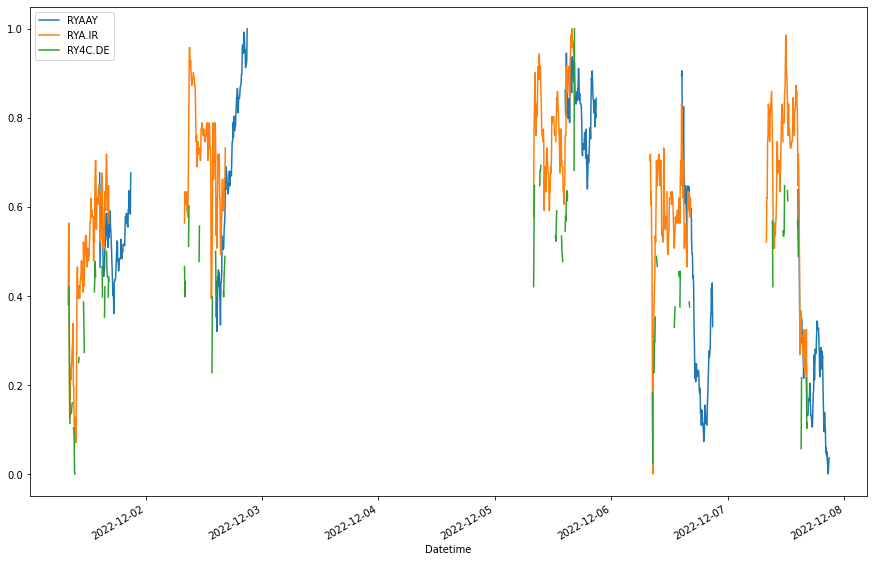

In [31]:
t2.plot(figsize=(15,10))

In [32]:
base_df, diff_df = df_basing(t2)

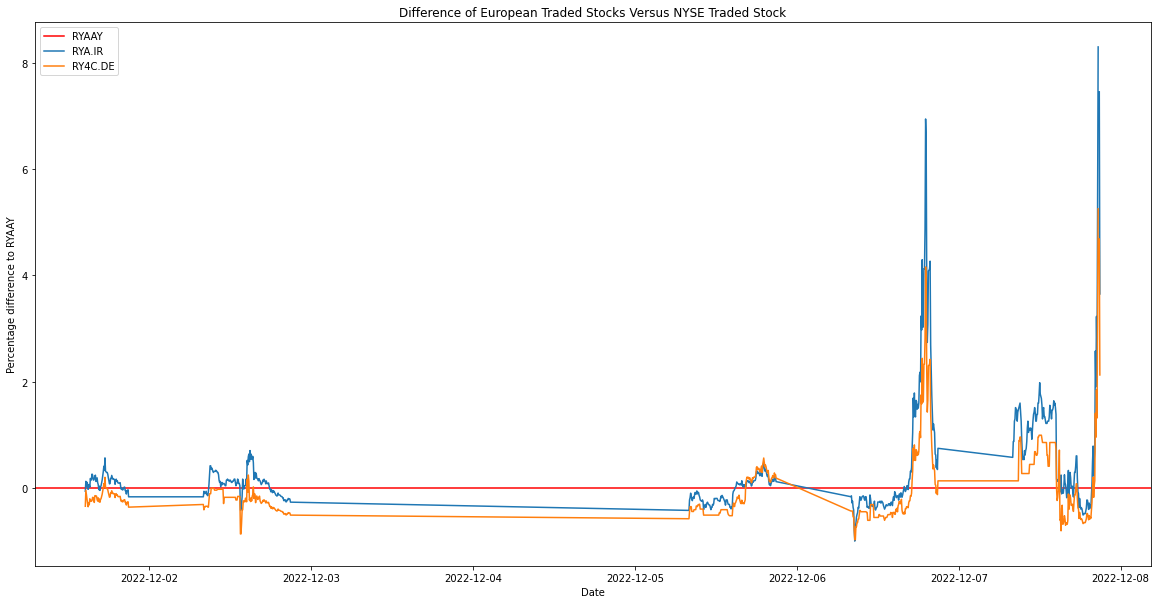

In [33]:
base_plot(test_tickers, diff_df)

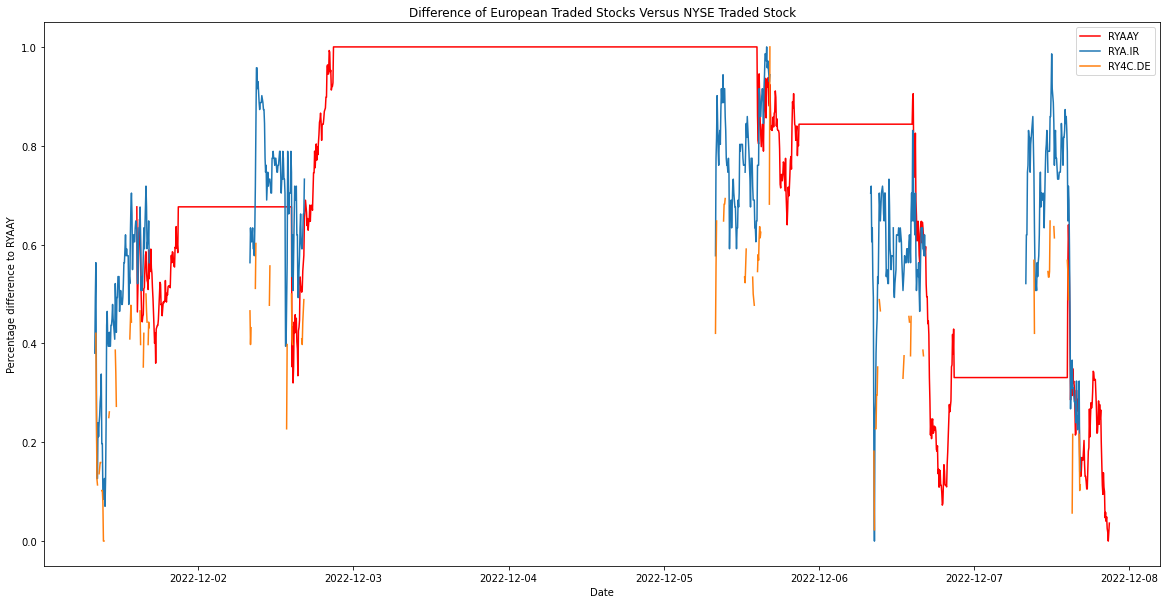

In [34]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
ax.plot(base_df, label=base_df.name , color = "r")
ax.plot(t2[test_tickers[-2:]],label=t2[test_tickers[-2:]].columns)
ax.set_title("Difference of European Traded Stocks Versus NYSE Traded Stock")
ax.set_xlabel("Date")
ax.set_ylabel(f"Percentage difference to {test_tickers[0]}")
ax.legend()

## Trading Test

In [15]:
from IntradayRegionArbitrage import IntradayRegionArbitrage as IRA

In [16]:
histories = {}

In [17]:
for row in tqdm(arb_df.iterrows()):
    traders = [IRA(bal=1000,min_deviation=0.1,sl_percent=0.03,trigger_range=0.01,trade_size=0.1,trade_size_percent=True),
               IRA(bal=1000,min_deviation=0.3,sl_percent=0.06,trigger_range=0.02,trade_size=0.1,trade_size_percent=True),
               IRA(bal=1000,min_deviation=0.6,sl_percent=0.09,trigger_range=0.04,trade_size=0.1,trade_size_percent=True),
               IRA(bal=1000,min_deviation=0.9,sl_percent=0.12,trigger_range=0.08,trade_size=0.1,trade_size_percent=True)]
    lst = list(row[1].dropna())
    if len(lst) > 1 and any("." in elem for elem in lst) and row[0] not in histories:
        histories[row[0]] = trade(traders, time_blocks, lst)

0it [00:00, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare RYAAY-> amt: -2.6190 @76.3650 --> total: -200.0000
		Ticker RYA.IR-> amt: 16.1994 @12.3461 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare RYAAY-> amt: 2.6190 @76.6900 --> total: 200.8512
		Ticker RYA.IR-> amt: -16.1994 @12.3708 --> total: -200.3996
	 PNL: 0.0452%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare RYAAY-> amt: -1.3153 @76.0600 --> total: -100.0452
		Ticker RY4C.DE-> amt: 8.0666 @12.4024 --> total: 100.0452
		BaseShare RYAAY-> amt: -1.3153 @76.0600 --> total: -100.0452
		Ticker RYA.IR-> amt: 8.0790 @12.3833 --> total: 100.0452
	--Opening Trade
		BaseShare RYAAY-> amt: -2.6295 @76.0600 --> total: -200.0000
		Ticker RYA.IR-> amt: 16.1507 @12.3833 --> total: 200.0000
	--Opening Trade
		BaseShare RYAAY-> amt: -2.6295 @76.0600 --> total: -200.0000
		Ticker RYA.IR-> amt: 16.1338 @12.3964 --> total: 200.0000
	take profit
	--Closing Trade

	--Opening Trade
		BaseShare RYAAY-> amt: -2.5276 @79.2000 --> total: -200.1854
		Ticker RY4C.F-> amt: 16.6741 @12.0058 --> total: 200.1854
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare RYAAY-> amt: 2.5276 @78.9250 --> total: 199.4903
		Ticker RY4C.F-> amt: -16.6741 @12.0058 --> total: -200.1854
	 PNL: -0.0694%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare RYAAY-> amt: 1.3058 @78.9250 --> total: 103.0623
		Ticker RY4D.DU-> amt: -1.5003 @69.2443 --> total: -103.8860
	 PNL: -0.0812%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare RYAAY-> amt: 1.3046 @78.9250 --> total: 102.9658
		Ticker RY4D.DU-> amt: -1.4849 @69.2443 --> total: -102.8212
	 PNL: 0.0144%
########################################## Market-Closing ##################################

	--Opening Trade
		BaseShare RYAAY-> amt: -0.5649 @89.0350 --> total: -50.2958
		Ticker RY4C.DE-> amt: 3.6993 @13.5961 --> total: 50.2958
		BaseShare RYAAY-> amt: -0.5649 @89.0350 --> total: -50.2958
		Ticker RY4C.F-> amt: 3.7249 @13.5027 --> total: 50.2958
		BaseShare RYAAY-> amt: -0.5649 @89.0350 --> total: -50.2958
		Ticker RY4D.DU-> amt: 0.6665 @75.4677 --> total: 50.2958
		BaseShare RYAAY-> amt: -0.5649 @89.0350 --> total: -50.2958
		Ticker RYA.IR-> amt: 3.7246 @13.5036 --> total: 50.2958
	take profit
	--Closing Trade
		BaseShare RYAAY-> amt: 0.5649 @89.5900 --> total: 50.6093
		Ticker RY4C.DE-> amt: -3.6993 @13.4387 --> total: -49.7135
	 PNL: 0.0891%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare RYAAY-> amt: 0.5649 @89.5900 --> total: 50.6093
		Ticker RY4C.F-> amt: -3.7249 @13.5303 --> total: -50.3987
	 PNL: 0.0209%
	--Closing Trade
		BaseShare RYAAY-> amt: 0.5649 @89.5900 --> total: 50.6093
		Ticker RYA.IR-> amt: -3.7246 @13.4573 --> total: -50.1233
	 PNL: 0.0483

	--Opening Trade
		BaseShare RYAAY-> amt: -0.7410 @92.4400 --> total: -68.4941
		Ticker RY4C.DE-> amt: 5.0564 @13.5462 --> total: 68.4941
		BaseShare RYAAY-> amt: -0.7410 @92.4400 --> total: -68.4941
		Ticker RY4D.DU-> amt: 0.8880 @77.1373 --> total: 68.4941
		BaseShare RYAAY-> amt: -0.7410 @92.4400 --> total: -68.4941
		Ticker RYA.IR-> amt: 5.0200 @13.6443 --> total: 68.4941
	--Opening Trade
		BaseShare RYAAY-> amt: -0.7361 @92.4400 --> total: -68.0455
		Ticker RY4C.DE-> amt: 5.0232 @13.5462 --> total: 68.0455
		BaseShare RYAAY-> amt: -0.7361 @92.4400 --> total: -68.0455
		Ticker RY4D.DU-> amt: 0.8821 @77.1373 --> total: 68.0455
		BaseShare RYAAY-> amt: -0.7361 @92.4400 --> total: -68.0455
		Ticker RYA.IR-> amt: 4.9871 @13.6443 --> total: 68.0455
	--Opening Trade
		BaseShare RYAAY-> amt: -0.7331 @92.4400 --> total: -67.7683
		Ticker RY4C.DE-> amt: 5.0028 @13.5462 --> total: 67.7683
		BaseShare RYAAY-> amt: -0.7331 @92.4400 --> total: -67.7683
		Ticker RY4D.DU-> amt: 0.8785 @77.1373 --

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare TSLA-> amt: -1.1581 @172.6900 --> total: -200.0000
		Ticker TL0.DE-> amt: 1.2766 @156.6601 --> total: 200.0000
	--Opening Trade
		BaseShare TSLA-> amt: -1.1581 @172.6900 --> total: -200.0000
		Ticker TL0.DE-> amt: 1.2766 @156.6601 --> total: 200.0000
	--Opening Trade
		BaseShare TSLA-> amt: -1.1581 @172.6900 --> total: -200.0000
		Ticker TL0.DE-> amt: 1.2766 @156.6601 --> total: 200.0000
	--Opening Trade
		BaseShare TSLA-> amt: -1.1581 @172.6900 --> total: -200.0000
		Ticker TL0.DE-> amt: 1.2766 @156.6601 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare TSLA-> amt: 1.1581 @174.6300 --> total: 202.2468
		Ticker TL0.DE-> amt: -1.2766 @158.3224 --> total: -202.1222
	 PNL: 0.0125%
	take profit
	--Closing Trade
		BaseShare TSLA-> amt: 1.1581 @172.9800 --> total: 200.3359
		Ticker TL0.DE-> amt: -1.2766 @157.1167 --> total: -200.5830
	 PNL: -0.0247%
	Market-Closing --> close Trades
########################################## Market-Closing ############

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare NFLX-> amt: -0.6455 @309.8300 --> total: -200.0000
		Ticker NFC.DE-> amt: 0.7126 @280.6630 --> total: 200.0000
	--Opening Trade
		BaseShare NFLX-> amt: -0.6455 @309.8300 --> total: -200.0000
		Ticker NFC.DE-> amt: 0.7126 @280.6630 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NFLX-> amt: 0.6455 @316.4050 --> total: 204.2443
		Ticker NFC.DE-> amt: -0.7126 @286.0482 --> total: -203.8375
	 PNL: 0.0407%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NFLX-> amt: 0.6455 @316.4050 --> total: 204.2443
		Ticker NFC.DE-> amt: -0.7126 @286.0482 --> total: -203.8375
	 PNL: 0.0407%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare NFLX-> amt: -0.6304 @317.3800 --> total: -200.0814
		Ticker NFLX.MI-> amt: 0.6863 @291.5495 --> total: 200.0814
	

	--Opening Trade
		BaseShare NFLX-> amt: -0.3419 @294.4000 --> total: -100.6588
		Ticker NFC.DE-> amt: 0.3816 @263.8026 --> total: 100.6588
		BaseShare NFLX-> amt: -0.3419 @294.4000 --> total: -100.6588
		Ticker NFLX.MI-> amt: 0.3805 @264.5088 --> total: 100.6588
	take profit
	--Closing Trade
		BaseShare NFLX-> amt: 0.3419 @295.1300 --> total: 100.9084
		Ticker NFC.DE-> amt: -0.3816 @262.6448 --> total: -100.2170
	 PNL: 0.0687%
	take profit
	--Closing Trade
		BaseShare NFLX-> amt: 0.3419 @294.9200 --> total: 100.8366
		Ticker NFLX.MI-> amt: -0.3805 @262.3014 --> total: -99.8187
	 PNL: 0.1010%
	--Opening Trade
		BaseShare NFLX-> amt: -0.3409 @295.7600 --> total: -100.8297
		Ticker NFC.DE-> amt: 0.3801 @265.2550 --> total: 100.8297
		BaseShare NFLX-> amt: -0.3409 @295.7600 --> total: -100.8297
		Ticker NFLX.MI-> amt: 0.3816 @264.2388 --> total: 100.8297
	take profit
	--Closing Trade
		BaseShare NFLX-> amt: 0.3409 @296.2799 --> total: 101.0069
		Ticker NFLX.MI-> amt: -0.3816 @262.9854 -->

	--Opening Trade
		BaseShare NFLX-> amt: -0.6416 @318.6650 --> total: -204.4546
		Ticker NFLX.MI-> amt: 0.7449 @274.4577 --> total: 204.4546
	--Opening Trade
		BaseShare NFLX-> amt: -0.6359 @318.6650 --> total: -202.6386
		Ticker NFLX.MI-> amt: 0.7383 @274.4577 --> total: 202.6386
	--Opening Trade
		BaseShare NFLX-> amt: -0.6371 @317.5001 --> total: -202.2871
		Ticker NFLX.MI-> amt: 0.7370 @274.4577 --> total: 202.2871
	--Opening Trade
		BaseShare NFLX-> amt: -0.6359 @317.5001 --> total: -201.9081
		Ticker NFLX.MI-> amt: 0.7357 @274.4577 --> total: 201.9081
	take profit
	--Closing Trade
		BaseShare NFLX-> amt: 0.6371 @324.1000 --> total: 206.4920
		Ticker NFLX.MI-> amt: -0.7370 @277.8300 --> total: -204.7726
	 PNL: 0.1700%
	take profit
	--Closing Trade
		BaseShare NFLX-> amt: 0.6359 @324.1000 --> total: 206.1052
		Ticker NFLX.MI-> amt: -0.7357 @277.8300 --> total: -204.3890
	 PNL: 0.1700%
	take profit
	--Closing Trade
		BaseShare NFLX-> amt: 0.6416 @319.8800 --> total: 205.2342
		Ticke

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare GOOG-> amt: -2.0048 @99.7600 --> total: -200.0000
		Ticker ABEA.DE-> amt: 2.2035 @90.7633 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare GOOG-> amt: 2.0048 @100.0300 --> total: 200.5413
		Ticker ABEA.DE-> amt: -2.2035 @90.5349 --> total: -199.4969
	 PNL: 0.1044%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare GOOG-> amt: -2.1439 @93.3835 --> total: -200.2089
		Ticker ABEA.DE-> amt: 2.3972 @83.5172 --> total: 200.2089
	--Opening Trade
		BaseShare GOOG-> amt: -2.1619 @92.5100 --> total: -200.0000
		Ticker ABEA.DE-> amt: 2.4226 @82.5574 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare GOOG-> amt: 2.1439 @92.1800 --> total: 197.6286
		Ticker ABEA.DE-> amt: -2.3972 @83.0805 --> total: -199.1620
	 PNL: -0.1532%
########################################## Market-Closing ##########################################
	Mark

	--Opening Trade
		BaseShare GOOG-> amt: -2.1567 @92.8000 --> total: -200.1393
		Ticker ABEA.DE-> amt: 2.5468 @78.5855 --> total: 200.1393
	--Opening Trade
		BaseShare GOOG-> amt: -2.1478 @92.8000 --> total: -199.3119
		Ticker ABEA.DE-> amt: 2.5362 @78.5855 --> total: 199.3119
	--Opening Trade
		BaseShare GOOG-> amt: -2.1518 @92.8000 --> total: -199.6877
		Ticker ABEA.DE-> amt: 2.5410 @78.5855 --> total: 199.6877
	--Opening Trade
		BaseShare GOOG-> amt: -2.1581 @92.5889 --> total: -199.8148
		Ticker ABEA.DE-> amt: 2.5474 @78.4384 --> total: 199.8148
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare GOOG-> amt: 2.1567 @92.9800 --> total: 200.5275
		Ticker ABEA.DE-> amt: -2.5468 @79.1816 --> total: -201.6574
	 PNL: -0.1129%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare GOOG-> amt: 2.1478 @92.9800 --> total: 199.6985
		Ticker ABEA.DE-> amt: -2.5362 @79.1816 --> 

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare BRK-B-> amt: -0.6359 @314.5100 --> total: -200.0000
		Ticker BRKB.VI-> amt: 0.6953 @287.6256 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BRK-B-> amt: 0.6359 @315.4900 --> total: 200.6232
		Ticker BRKB.VI-> amt: -0.6953 @286.0460 --> total: -198.9016
	 PNL: 0.1722%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare BRK-B-> amt: -0.6365 @314.7750 --> total: -200.3443
		Ticker BRKA.VI-> amt: 0.0005 @428767.1974 --> total: 200.3443
	--Opening Trade
		BaseShare BRK-B-> amt: -0.6354 @314.7750 --> total: -200.0000
		Ticker BRKA.VI-> amt: 0.0005 @428767.1974 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BRK-B-> amt: 0.6365 @313.4300 --> total: 199.4883
		Ticker BRKA.VI-> amt: -0.0005 @428605.6919 --> total: -200.2688
	 PNL: -0.0779%
########################################## Market-Closing #########################

	--Opening Trade
		BaseShare BRK-B-> amt: -0.3313 @305.6100 --> total: -101.2549
		Ticker BRKB.VI-> amt: 0.3720 @272.2131 --> total: 101.2549
		BaseShare BRK-B-> amt: -0.3313 @305.6100 --> total: -101.2549
		Ticker BRKA.VI-> amt: 0.0002 @413512.0106 --> total: 101.2549
	--Opening Trade
		BaseShare BRK-B-> amt: -0.3291 @305.6100 --> total: -100.5904
		Ticker BRKB.VI-> amt: 0.3695 @272.2131 --> total: 100.5904
		BaseShare BRK-B-> amt: -0.3291 @305.6100 --> total: -100.5904
		Ticker BRKA.VI-> amt: 0.0002 @413512.0106 --> total: 100.5904
	--Opening Trade
		BaseShare BRK-B-> amt: -0.3299 @304.0500 --> total: -100.2913
		Ticker BRKB.VI-> amt: 0.3684 @272.2131 --> total: 100.2913
		BaseShare BRK-B-> amt: -0.3299 @304.0500 --> total: -100.2913
		Ticker BRKA.VI-> amt: 0.0002 @413512.0106 --> total: 100.2913
	--Opening Trade
		BaseShare BRK-B-> amt: -0.3302 @303.0300 --> total: -100.0490
		Ticker BRKB.VI-> amt: 0.3675 @272.2131 --> total: 100.0490
		BaseShare BRK-B-> amt: -0.3302 @303.0300 --> t

	--Opening Trade
		BaseShare BRK-B-> amt: -0.6444 @314.9800 --> total: -202.9652
		Ticker BRKA.VI-> amt: 0.0005 @414294.9975 --> total: 202.9652
	--Opening Trade
		BaseShare BRK-B-> amt: -0.6390 @314.9800 --> total: -201.2720
		Ticker BRKA.VI-> amt: 0.0005 @414294.9975 --> total: 201.2720
	--Opening Trade
		BaseShare BRK-B-> amt: -0.6374 @314.9800 --> total: -200.7795
		Ticker BRKA.VI-> amt: 0.0005 @414294.9975 --> total: 200.7795
	--Opening Trade
		BaseShare BRK-B-> amt: -0.6368 @314.9800 --> total: -200.5703
		Ticker BRKA.VI-> amt: 0.0005 @414294.9975 --> total: 200.5703
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BRK-B-> amt: 0.6444 @314.9100 --> total: 202.9200
		Ticker BRKA.VI-> amt: -0.0005 @414007.3005 --> total: -202.8242
	 PNL: 0.0094%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BRK-B-> amt: 0.6390 @314.9100 --> total: 201.2273
		Ticker BRKA.

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare AMZN-> amt: -2.2432 @89.1600 --> total: -200.0000
		Ticker AMZ.DE-> amt: 2.4700 @80.9710 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare AMZN-> amt: 2.2432 @89.5000 --> total: 200.7627
		Ticker AMZ.DE-> amt: -2.4700 @80.8125 --> total: -199.6085
	 PNL: 0.1154%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare AMZN-> amt: -2.2767 @87.9488 --> total: -200.2308
		Ticker AMZ.DE-> amt: 2.5184 @79.5082 --> total: 200.2308
	--Opening Trade
		BaseShare AMZN-> amt: -2.2771 @87.8300 --> total: -200.0000
		Ticker AMZ.DE-> amt: 2.5138 @79.5614 --> total: 200.0000
	--Opening Trade
		BaseShare AMZN-> amt: -2.2771 @87.8300 --> total: -200.0000
		Ticker AMZ.DE-> amt: 2.5138 @79.5614 --> total: 200.0000
	--Opening Trade
		BaseShare AMZN-> amt: -2.2771 @87.8300 --> total: -200.0000
		Ticker AMZ.DE-> amt: 2.5138 @79.5614 --> total: 200.0000
	take profit
	--Closing

	--Opening Trade
		BaseShare AMZN-> amt: -2.0987 @95.3100 --> total: -200.0280
		Ticker AMZ.DE-> amt: 2.4558 @81.4502 --> total: 200.0280
	--Opening Trade
		BaseShare AMZN-> amt: -2.1255 @93.9300 --> total: -199.6481
		Ticker AMZ.DE-> amt: 2.4749 @80.6692 --> total: 199.6481
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare AMZN-> amt: 2.0987 @93.0550 --> total: 195.2954
		Ticker AMZ.DE-> amt: -2.4558 @79.9687 --> total: -196.3898
	 PNL: -0.1094%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare AMZN-> amt: 2.1255 @93.0550 --> total: 197.7883
		Ticker AMZ.DE-> amt: -2.4749 @79.9687 --> total: -197.9144
	 PNL: -0.0126%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare AMZN-> amt: -2.1347 @93.6000 --> total: -199.8091
		Ticker AMZ.DE-> amt: 2.4943 @80.1050 --> total: 199.8091
	take prof

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare AAPL-> amt: -0.6805 @146.9400 --> total: -100.0000
		Ticker APC.DE-> amt: 0.7487 @133.5635 --> total: 100.0000
		BaseShare AAPL-> amt: -0.6805 @146.9400 --> total: -100.0000
		Ticker APC.F-> amt: 0.7490 @133.5063 --> total: 100.0000
	take profit
	--Closing Trade
		BaseShare AAPL-> amt: 0.6805 @147.7450 --> total: 100.5478
		Ticker APC.F-> amt: -0.7490 @133.5185 --> total: -100.0091
	 PNL: 0.0539%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare AAPL-> amt: 0.6805 @147.9500 --> total: 100.6874
		Ticker APC.DE-> amt: -0.7487 @134.2354 --> total: -100.5031
	 PNL: 0.0184%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare AAPL-> amt: -1.3660 @146.5152 --> total: -200.1446
		Ticker APC.DE-> amt: 1.4979 @133.6160 --> total: 200.1446
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare AAPL-> amt: 1.3660 @146.5490 --> total: 200.1908
		Ticker APC.DE-> amt: -1.4979 

	take profit
	--Closing Trade
		BaseShare AAPL-> amt: 0.7761 @129.9500 --> total: 100.8579
		Ticker APC.F-> amt: -0.8753 @115.9641 --> total: -101.4990
	 PNL: -0.0634%
	--Opening Trade
		BaseShare AAPL-> amt: -1.5969 @126.4901 --> total: -201.9976
		Ticker APC.F-> amt: 1.7654 @114.4217 --> total: 201.9976
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare AAPL-> amt: 1.5969 @126.6000 --> total: 202.1731
		Ticker APC.F-> amt: -1.7654 @114.1679 --> total: -201.5495
	 PNL: 0.0617%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare AAPL-> amt: -1.5562 @129.8800 --> total: -202.1223
		Ticker APC.DE-> amt: 1.7941 @112.6575 --> total: 202.1223
	--Opening Trade
		BaseShare AAPL-> amt: -1.5463 @130.1500 --> total: -201.2490
		Ticker APC.F-> amt: 1.7773 @113.2347 --> total: 201.2490
	--Opening Trade
		BaseShare AAPL-> amt: -1.5591 @128.8000 --> total: -200.8131
		Ticker APC.F-> amt: 1.7885 @112.2819 --> tot

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare MSFT-> amt: -0.7998 @250.0700 --> total: -200.0000
		Ticker MSF.DE-> amt: 0.8774 @227.9346 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare MSFT-> amt: 0.7998 @251.3900 --> total: 201.0557
		Ticker MSF.DE-> amt: -0.8774 @228.3153 --> total: -200.3341
	 PNL: 0.0722%
	--Opening Trade
		BaseShare MSFT-> amt: -0.8038 @249.0000 --> total: -200.1443
		Ticker MSF.DE-> amt: 0.8848 @226.1951 --> total: 200.1443
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare MSFT-> amt: 0.8038 @246.6300 --> total: 198.2393
		Ticker MSF.DE-> amt: -0.8848 @222.9163 --> total: -197.2431
	 PNL: 0.0995%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare MSFT-> amt: -0.8190 @244.6300 --> total: -200.3436
		Ticker MSF.DE-> amt: 0.9068 @220.9244 --> total: 200.3436
	--Opening Trade
		BaseShare MSFT-> amt: -0.8176 @244.6300 --> total: -200.0000
		Ticker MSF.DE-> amt: 0.9053 @220.9244 -->

	--Opening Trade
		BaseShare MSFT-> amt: -0.8529 @234.7300 --> total: -200.1968
		Ticker MSF.DE-> amt: 0.9977 @200.6683 --> total: 200.1968
	--Opening Trade
		BaseShare MSFT-> amt: -0.8498 @234.7300 --> total: -199.4851
		Ticker MSF.DE-> amt: 0.9941 @200.6683 --> total: 199.4851
	--Opening Trade
		BaseShare MSFT-> amt: -0.8605 @232.2900 --> total: -199.8744
		Ticker MSF.DE-> amt: 1.0059 @198.7115 --> total: 199.8744
	--Opening Trade
		BaseShare MSFT-> amt: -0.8632 @232.1550 --> total: -200.3949
		Ticker MSF.DE-> amt: 1.0073 @198.9362 --> total: 200.3949
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare MSFT-> amt: 0.8529 @230.7600 --> total: 196.8109
		Ticker MSF.DE-> amt: -0.9977 @198.3243 --> total: -197.8583
	 PNL: -0.1046%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare MSFT-> amt: 0.8498 @230.7600 --> total: 196.1112
		Ticker MSF.DE-> amt: -0.9941 @198.324

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare GM-> amt: -2.4432 @40.9300 --> total: -100.0000
		Ticker 8GM.F-> amt: 2.7121 @36.8716 --> total: 100.0000
		BaseShare GM-> amt: -2.4432 @40.9300 --> total: -100.0000
		Ticker GMOT.VI-> amt: 2.7048 @36.9714 --> total: 100.0000
	take profit
	--Closing Trade
		BaseShare GM-> amt: 2.4432 @41.3501 --> total: 101.0264
		Ticker 8GM.F-> amt: -2.7121 @36.8716 --> total: -100.0000
	 PNL: 0.1026%
	take profit
	--Closing Trade
		BaseShare GM-> amt: 2.4432 @41.3400 --> total: 101.0017
		Ticker GMOT.VI-> amt: -2.7048 @36.9714 --> total: -100.0000
	 PNL: 0.1001%
	--Opening Trade
		BaseShare GM-> amt: -1.6337 @40.8901 --> total: -66.8019
		Ticker 8GM.DE-> amt: 1.7923 @37.2710 --> total: 66.8019
		BaseShare GM-> amt: -1.6337 @40.8901 --> total: -66.8019
		Ticker 8GM.F-> amt: 1.8117 @36.8716 --> total: 66.8019
		BaseShare GM-> amt: -1.6337 @40.8901 --> total: -66.8019
		Ticker GMOT.VI-> amt: 1.8069 @36.9714 --> total: 66.8019
	Market-Closing --> close Trades
	--Closing Trade

	--Opening Trade
		BaseShare GM-> amt: -5.6347 @35.6200 --> total: -200.7064
		Ticker 8GM.DE-> amt: 6.3233 @31.7407 --> total: 200.7064
	take profit
	--Closing Trade
		BaseShare GM-> amt: 5.6347 @35.9000 --> total: 202.2841
		Ticker 8GM.DE-> amt: -6.3233 @31.6082 --> total: -199.8682
	 PNL: 0.2407%
	--Opening Trade
		BaseShare GM-> amt: -1.9260 @34.8200 --> total: -67.0632
		Ticker 8GM.DE-> amt: 2.1371 @31.3799 --> total: 67.0632
		BaseShare GM-> amt: -1.9260 @34.8200 --> total: -67.0632
		Ticker 8GM.F-> amt: 2.1148 @31.7121 --> total: 67.0632
		BaseShare GM-> amt: -1.9260 @34.8200 --> total: -67.0632
		Ticker GMOT.VI-> amt: 2.1217 @31.6075 --> total: 67.0632
	--Opening Trade
		BaseShare GM-> amt: -1.9251 @34.8200 --> total: -67.0323
		Ticker 8GM.DE-> amt: 2.1362 @31.3799 --> total: 67.0323
		BaseShare GM-> amt: -1.9251 @34.8200 --> total: -67.0323
		Ticker 8GM.F-> amt: 2.1138 @31.7121 --> total: 67.0323
		BaseShare GM-> amt: -1.9251 @34.8200 --> total: -67.0323
		Ticker GMOT.VI-> amt:

	Market-Closing --> close Trades
	--Closing Trade
		BaseShare GM-> amt: 2.0181 @33.8900 --> total: 68.3949
		Ticker 8GM.F-> amt: -2.2492 @30.4653 --> total: -68.5219
	 PNL: -0.0126%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare GM-> amt: 2.0195 @33.8900 --> total: 68.4393
		Ticker 8GM.F-> amt: -2.2506 @30.4653 --> total: -68.5663
	 PNL: -0.0126%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare GM-> amt: 2.0077 @33.8900 --> total: 68.0413
		Ticker 8GM.F-> amt: -2.2375 @30.4653 --> total: -68.1676
	 PNL: -0.0126%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare GM-> amt: 2.0116 @33.8900 --> total: 68.1726
		Ticker 8GM.F-> amt: -2.2419 @30.4653 --> t

	--Opening Trade
		BaseShare GM-> amt: -1.8902 @35.6800 --> total: -67.4418
		Ticker 8GM.DE-> amt: 2.2118 @30.4920 --> total: 67.4418
		BaseShare GM-> amt: -1.8902 @35.6800 --> total: -67.4418
		Ticker 8GM.F-> amt: 2.1910 @30.7810 --> total: 67.4418
		BaseShare GM-> amt: -1.8902 @35.6800 --> total: -67.4418
		Ticker GMOT.VI-> amt: 2.1866 @30.8434 --> total: 67.4418
	--Opening Trade
		BaseShare GM-> amt: -1.8926 @35.6800 --> total: -67.5285
		Ticker 8GM.DE-> amt: 2.2146 @30.4920 --> total: 67.5285
		BaseShare GM-> amt: -1.8926 @35.6800 --> total: -67.5285
		Ticker 8GM.F-> amt: 2.1938 @30.7810 --> total: 67.5285
		BaseShare GM-> amt: -1.8926 @35.6800 --> total: -67.5285
		Ticker GMOT.VI-> amt: 2.1894 @30.8434 --> total: 67.5285
	--Opening Trade
		BaseShare GM-> amt: -2.8221 @35.6800 --> total: -100.6913
		Ticker 8GM.F-> amt: 3.2712 @30.7810 --> total: 100.6913
		BaseShare GM-> amt: -2.8221 @35.6800 --> total: -100.6913
		Ticker GMOT.VI-> amt: 3.2646 @30.8434 --> total: 100.6913
	--Openin

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare META-> amt: -1.6609 @120.4150 --> total: -200.0000
		Ticker FB2A.DE-> amt: 1.8350 @108.9924 --> total: 200.0000
	--Opening Trade
		BaseShare META-> amt: -1.6818 @118.9201 --> total: -200.0000
		Ticker FB2A.BE-> amt: 1.8455 @108.3722 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare META-> amt: 1.6818 @120.0900 --> total: 201.9675
		Ticker FB2A.BE-> amt: -1.8455 @108.0171 --> total: -199.3447
	 PNL: 0.2623%
	--Opening Trade
		BaseShare META-> amt: -1.6805 @119.3250 --> total: -200.5246
		Ticker FB2A.BE-> amt: 1.8375 @109.1299 --> total: 200.5246
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare META-> amt: 1.6609 @119.8400 --> total: 199.0450
		Ticker FB2A.DE-> amt: -1.8350 @108.4935 --> total: -199.0845
	 PNL: -0.0040%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare META-> amt: 1.6805 @119.8400 --> total: 201.3900
		Tick

	--Opening Trade
		BaseShare META-> amt: -1.7449 @116.1550 --> total: -202.6783
		Ticker FB2A.BE-> amt: 1.9510 @103.8855 --> total: 202.6783
	--Opening Trade
		BaseShare META-> amt: -1.7443 @116.1550 --> total: -202.6069
		Ticker FB2A.BE-> amt: 1.9503 @103.8855 --> total: 202.6069
	take profit
	--Closing Trade
		BaseShare META-> amt: 1.7443 @117.9250 --> total: 205.6943
		Ticker FB2A.BE-> amt: -1.9503 @104.8369 --> total: -204.4624
	 PNL: 0.1216%
	take profit
	--Closing Trade
		BaseShare META-> amt: 1.7449 @119.5839 --> total: 208.6614
		Ticker FB2A.BE-> amt: -1.9510 @106.1710 --> total: -207.1372
	 PNL: 0.1504%
	Market-Closing --> close Trades
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare META-> amt: -1.7309 @117.2700 --> total: -202.9832
		Ticker FB2A.BE-> amt: 1.9325 @105.0356 --> total: 202.9832
	--Opening Trade
		BaseShare META-> amt: -1.7298 @117.2700 --> total: -202.8533
		Ticker FB2A.BE-> amt: 1

	--Opening Trade
		BaseShare META-> amt: -1.5260 @134.3426 --> total: -205.0006
		Ticker FB2A.DE-> amt: 1.7853 @114.8287 --> total: 205.0006
	--Opening Trade
		BaseShare META-> amt: -1.5210 @134.3426 --> total: -204.3294
		Ticker FB2A.DE-> amt: 1.7794 @114.8287 --> total: 204.3294
	--Opening Trade
		BaseShare META-> amt: -1.5141 @134.3426 --> total: -203.4098
		Ticker FB2A.DE-> amt: 1.7714 @114.8287 --> total: 203.4098
	--Opening Trade
		BaseShare META-> amt: -1.4961 @134.3426 --> total: -200.9883
		Ticker FB2A.DE-> amt: 1.7503 @114.8287 --> total: 200.9883
	take profit
	--Closing Trade
		BaseShare META-> amt: 1.5141 @134.8750 --> total: 204.2159
		Ticker FB2A.DE-> amt: -1.7714 @114.0771 --> total: -202.0785
	 PNL: 0.2102%
	take profit
	--Closing Trade
		BaseShare META-> amt: 1.4961 @134.8750 --> total: 201.7848
		Ticker FB2A.DE-> amt: -1.7503 @114.0771 --> total: -199.6728
	 PNL: 0.2102%
	--Opening Trade
		BaseShare META-> amt: -1.5143 @134.6100 --> total: -203.8373
		Ticker FB2A.BE->

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare PFE-> amt: -3.9432 @50.7200 --> total: -200.0000
		Ticker PFE.F-> amt: 4.3344 @46.1429 --> total: 200.0000
	--Opening Trade
		BaseShare PFE-> amt: -3.9502 @50.6299 --> total: -200.0000
		Ticker PFE.F-> amt: 4.3344 @46.1429 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare PFE-> amt: 3.9432 @50.5650 --> total: 199.3888
		Ticker PFE.F-> amt: -4.3344 @45.8054 --> total: -198.5373
	 PNL: 0.0852%
	Market-Closing --> close Trades
########################################## Market-Closing ##########################################
	take profit
	--Closing Trade
		BaseShare PFE-> amt: 3.9502 @50.5650 --> total: 199.7436
		Ticker PFE.F-> amt: -4.3344 @45.8054 --> total: -198.5373
	 PNL: 0.1206%
	Market-Closing --> close Trades
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare PFE-> amt: -3.9466 @50.7200 --> total: -200.1703
		Ticker PFE.F-> amt: 4.3114 @46.4282 --> total: 200.1

	--Opening Trade
		BaseShare PFE-> amt: -3.9840 @50.9463 --> total: -202.9703
		Ticker PFE.F-> amt: 4.3755 @46.3882 --> total: 202.9703
	take profit
	--Closing Trade
		BaseShare PFE-> amt: 3.9840 @51.2100 --> total: 204.0209
		Ticker PFE.F-> amt: -4.3755 @46.3882 --> total: -202.9703
	 PNL: 0.1035%
	--Opening Trade
		BaseShare PFE-> amt: -3.9820 @51.0250 --> total: -203.1804
		Ticker PFE.F-> amt: 4.3800 @46.3882 --> total: 203.1804
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare PFE-> amt: 3.9820 @50.9700 --> total: 202.9614
		Ticker PFE.F-> amt: -4.3800 @46.3882 --> total: -203.1804
	 PNL: -0.0216%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare PFE-> amt: -4.0914 @49.6500 --> total: -203.1366
		Ticker PFE.F-> amt: 4.5615 @44.5330 --> total: 203.1366
	take profit
	--Closing Trade
		BaseShare PFE-> amt: 4.0914 @49.7300 --> total: 203.4639
		Ticker PFE.F-> amt: -4.5615 @44.5330 --> total: -20

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare PEP-> amt: -1.0977 @182.2006 --> total: -200.0000
		Ticker PEP.DE-> amt: 1.2073 @165.6642 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare PEP-> amt: 1.0977 @182.1700 --> total: 199.9664
		Ticker PEP.DE-> amt: -1.2073 @165.5950 --> total: -199.9164
	 PNL: 0.0050%
	--Opening Trade
		BaseShare PEP-> amt: -1.1050 @181.0100 --> total: -200.0100
		Ticker PEP.DE-> amt: 1.2146 @164.6672 --> total: 200.0100
	--Opening Trade
		BaseShare PEP-> amt: -1.1049 @181.0100 --> total: -200.0000
		Ticker PEP.DE-> amt: 1.2146 @164.6672 --> total: 200.0000
	--Opening Trade
		BaseShare PEP-> amt: -1.1049 @181.0100 --> total: -200.0000
		Ticker PEP.DE-> amt: 1.2146 @164.6672 --> total: 200.0000
	--Opening Trade
		BaseShare PEP-> amt: -1.1049 @181.0100 --> total: -200.0000
		Ticker PEP.DE-> amt: 1.2146 @164.6672 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare PEP-> amt: 1.1049 @181.8200 --> total: 200.8950
		Ticker PEP.DE-> amt: -1.2146 @164.6672 --> tot

	--Opening Trade
		BaseShare PEP-> amt: -1.1245 @178.1500 --> total: -200.3260
		Ticker PEP.DE-> amt: 1.2920 @155.0515 --> total: 200.3260
	take profit
	--Closing Trade
		BaseShare PEP-> amt: 1.1245 @178.5100 --> total: 200.7308
		Ticker PEP.DE-> amt: -1.2920 @154.9377 --> total: -200.1790
	 PNL: 0.0551%
	--Opening Trade
		BaseShare PEP-> amt: -1.1255 @178.0920 --> total: -200.4364
		Ticker PEP.DE-> amt: 1.2937 @154.9377 --> total: 200.4364
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare PEP-> amt: 1.1255 @177.7600 --> total: 200.0627
		Ticker PEP.DE-> amt: -1.2937 @154.4095 --> total: -199.7532
	 PNL: 0.0309%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare PEP-> amt: -1.1230 @178.5450 --> total: -200.4983
		Ticker PEP.DE-> amt: 1.2938 @154.9685 --> total: 200.4983
	--Opening Trade
		BaseShare PEP-> amt: -1.1269 @177.9400 --> total: -200.5249
		Ticker PEP.DE-> amt: 1.2940 @154.9685 --> total

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare INTC-> amt: -6.6225 @30.2000 --> total: -200.0000
		Ticker INL.F-> amt: 7.2506 @27.5840 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare INTC-> amt: 6.6225 @30.4551 --> total: 201.6894
		Ticker INL.F-> amt: -7.2506 @27.5840 --> total: -200.0000
	 PNL: 0.1689%
	--Opening Trade
		BaseShare INTC-> amt: -6.6315 @30.2101 --> total: -200.3379
		Ticker INL.F-> amt: 7.2628 @27.5840 --> total: 200.3379
	--Opening Trade
		BaseShare INTC-> amt: -6.7024 @29.8400 --> total: -200.0000
		Ticker INL.F-> amt: 7.2506 @27.5840 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare INTC-> amt: 6.6315 @29.7650 --> total: 197.3862
		Ticker INL.F-> amt: -7.2628 @26.9341 --> total: -195.6181
	 PNL: 0.1765%
	take profit
	--Closing Trade
		BaseShare INTC-> amt: 6.7024 @29.7650 --> total: 199.4973
		Ticker INL.F-> amt: -7.2506 @26.9341 --> total: -195.2882
	 PNL: 0.4209%
	--Opening Trade
		BaseShare INTC-> amt: -6.7391 @29.7800 --> total: -200.6915
		Ticker INL.DE

	--Opening Trade
		BaseShare INTC-> amt: -7.7561 @26.1600 --> total: -202.8990
		Ticker INL.F-> amt: 8.6720 @23.3970 --> total: 202.8990
	--Opening Trade
		BaseShare INTC-> amt: -7.7559 @26.0769 --> total: -202.2498
		Ticker INL.F-> amt: 8.6442 @23.3970 --> total: 202.2498
	take profit
	--Closing Trade
		BaseShare INTC-> amt: 7.7559 @26.0950 --> total: 202.3902
		Ticker INL.F-> amt: -8.6442 @23.1830 --> total: -200.3999
	 PNL: 0.1968%
	--Opening Trade
		BaseShare INTC-> amt: -7.8212 @25.9100 --> total: -202.6478
		Ticker INL.F-> amt: 8.7381 @23.1912 --> total: 202.6478
	take profit
	--Closing Trade
		BaseShare INTC-> amt: 7.8212 @25.7100 --> total: 201.0836
		Ticker INL.F-> amt: -8.7381 @22.8652 --> total: -199.7989
	 PNL: 0.1268%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare INTC-> amt: 7.7561 @25.5650 --> total: 198.2841
		Ticker INL.F-> amt: -8.6720 @22.8303 --> total: -197.9841
	 PNL: 0.0296%
########################################## Market-Closing ################

	--Opening Trade
		BaseShare INTC-> amt: -6.9773 @29.2593 --> total: -204.1511
		Ticker INL.DE-> amt: 8.0295 @25.4251 --> total: 204.1511
	--Opening Trade
		BaseShare INTC-> amt: -6.9808 @29.2593 --> total: -204.2547
		Ticker INL.DE-> amt: 8.0336 @25.4251 --> total: 204.2547
	take profit
	--Closing Trade
		BaseShare INTC-> amt: 6.9773 @29.1800 --> total: 203.5978
		Ticker INL.DE-> amt: -8.0295 @25.2739 --> total: -202.9373
	 PNL: 0.0647%
	take profit
	--Closing Trade
		BaseShare INTC-> amt: 6.9808 @29.1800 --> total: 203.7011
		Ticker INL.DE-> amt: -8.0336 @25.2739 --> total: -203.0403
	 PNL: 0.0647%
	--Opening Trade
		BaseShare INTC-> amt: -6.9984 @29.1900 --> total: -204.2832
		Ticker INL.F-> amt: 8.0684 @25.3189 --> total: 204.2832
	--Opening Trade
		BaseShare INTC-> amt: -6.9948 @29.2200 --> total: -204.3868
		Ticker INL.F-> amt: 8.0635 @25.3471 --> total: 204.3868
	--Opening Trade
		BaseShare INTC-> amt: -6.9446 @29.1450 --> total: -202.4000
		Ticker INL.F-> amt: 7.9851 @25.3471 -

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare IBM-> amt: -1.3496 @148.1900 --> total: -200.0000
		Ticker IBM.F-> amt: 1.4825 @134.9085 --> total: 200.0000
	--Opening Trade
		BaseShare IBM-> amt: -1.3524 @147.8800 --> total: -200.0000
		Ticker IBM.F-> amt: 1.4825 @134.9085 --> total: 200.0000
	--Opening Trade
		BaseShare IBM-> amt: -1.3549 @147.6100 --> total: -200.0000
		Ticker IBM.F-> amt: 1.4825 @134.9085 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare IBM-> amt: 1.3496 @147.8950 --> total: 199.6019
		Ticker IBM.F-> amt: -1.4825 @134.9085 --> total: -200.0000
	 PNL: -0.0398%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare IBM-> amt: 1.3524 @147.8950 --> total: 200.0203
		Ticker IBM.F-> amt: -1.4825 @134.9085 --> total: -200.0000
	 PNL: 0.0020%
########################################## Market-Closing ##########################################
	Market-Clo

	--Opening Trade
		BaseShare IBM-> amt: -1.4224 @140.8800 --> total: -200.3884
		Ticker IBM.F-> amt: 1.6020 @125.0838 --> total: 200.3884
	--Opening Trade
		BaseShare IBM-> amt: -1.4220 @140.8800 --> total: -200.3375
		Ticker IBM.F-> amt: 1.6016 @125.0838 --> total: 200.3375
	--Opening Trade
		BaseShare IBM-> amt: -1.4213 @140.8800 --> total: -200.2344
		Ticker IBM.F-> amt: 1.6008 @125.0838 --> total: 200.2344
	--Opening Trade
		BaseShare IBM-> amt: -1.4185 @141.0900 --> total: -200.1381
		Ticker IBM.F-> amt: 1.5756 @127.0274 --> total: 200.1381
	take profit
	--Closing Trade
		BaseShare IBM-> amt: 1.4185 @141.4800 --> total: 200.6914
		Ticker IBM.F-> amt: -1.5756 @126.0640 --> total: -198.6202
	 PNL: 0.2070%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare IBM-> amt: 1.4224 @140.7150 --> total: 200.1537
		Ticker IBM.F-> amt: -1.6020 @126.0640 --> total: -201.9587
	 PNL: -0.1801%
########################################## Market-Closing #####################################

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare DIS-> amt: -2.0575 @97.2072 --> total: -200.0000
		Ticker WDP.DE-> amt: 2.2555 @88.6736 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DIS-> amt: 2.0575 @98.9200 --> total: 203.5240
		Ticker WDP.DE-> amt: -2.2555 @89.8677 --> total: -202.6933
	 PNL: 0.0831%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare DIS-> amt: -2.1211 @94.3675 --> total: -200.1661
		Ticker WDP.DE-> amt: 2.3316 @85.8483 --> total: 200.1661
	take profit
	--Closing Trade
		BaseShare DIS-> amt: 2.1211 @93.3138 --> total: 197.9311
		Ticker WDP.DE-> amt: -2.3316 @84.3474 --> total: -196.6665
	 PNL: 0.1264%
	--Opening Trade
		BaseShare DIS-> amt: -2.1773 @92.0500 --> total: -200.4191
		Ticker WDP.DE-> amt: 2.4068 @83.2726 --> total: 200.4191
	--Opening Trade
		BaseShare DIS-> amt: -2.1692 @92.2000 --> total: -200.0000
		Ticker WDP.DE-> amt: 2.3866 @83.7995 --> total: 200.0000
	

	--Opening Trade
		BaseShare DIS-> amt: -2.0501 @97.7000 --> total: -200.2965
		Ticker WDP.DE-> amt: 2.3916 @83.7508 --> total: 200.2965
	--Opening Trade
		BaseShare DIS-> amt: -2.0519 @97.7000 --> total: -200.4699
		Ticker WDP.DE-> amt: 2.3936 @83.7508 --> total: 200.4699
	--Opening Trade
		BaseShare DIS-> amt: -2.0552 @97.7000 --> total: -200.7931
		Ticker WDP.DE-> amt: 2.3975 @83.7508 --> total: 200.7931
	take profit
	--Closing Trade
		BaseShare DIS-> amt: 2.0552 @97.5581 --> total: 200.5015
		Ticker WDP.DE-> amt: -2.3975 @83.4898 --> total: -200.1673
	 PNL: 0.0333%
	--Opening Trade
		BaseShare DIS-> amt: -2.0612 @97.4500 --> total: -200.8599
		Ticker WDP.DE-> amt: 2.4037 @83.5629 --> total: 200.8599
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DIS-> amt: 2.0197 @97.7300 --> total: 197.3880
		Ticker WDP.DE-> amt: -2.3591 @83.8584 --> total: -197.8310
	 PNL: -0.0441%
########################################## Market-Closing ##########################################


  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare BA-> amt: -1.1215 @178.3400 --> total: -200.0000
		Ticker BCO.DE-> amt: 1.2345 @162.0044 --> total: 200.0000
	--Opening Trade
		BaseShare BA-> amt: -1.1292 @177.1200 --> total: -200.0000
		Ticker BCO.F-> amt: 1.2324 @162.2859 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare BA-> amt: 1.1292 @177.5300 --> total: 200.4630
		Ticker BCO.F-> amt: -1.2324 @160.4486 --> total: -197.7358
	 PNL: 0.2727%
	--Opening Trade
		BaseShare BA-> amt: -1.1373 @176.3400 --> total: -200.5454
		Ticker BCO.F-> amt: 1.2499 @160.4486 --> total: 200.5454
	--Opening Trade
		BaseShare BA-> amt: -1.1414 @175.2200 --> total: -200.0000
		Ticker BCO.F-> amt: 1.2465 @160.4486 --> total: 200.0000
	--Opening Trade
		BaseShare BA-> amt: -1.1414 @175.2200 --> total: -200.0000
		Ticker BCO.F-> amt: 1.2465 @160.4486 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BA-> amt: 1.1215 @177.4100 --> total: 198.9571
		Ticker BCO.DE-> amt: -1.2345 @160.5109

	--Opening Trade
		BaseShare BA-> amt: -1.0568 @191.1597 --> total: -202.0119
		Ticker BCO.DE-> amt: 1.1852 @170.4402 --> total: 202.0119
	take profit
	--Closing Trade
		BaseShare BA-> amt: 1.0568 @194.3600 --> total: 205.3939
		Ticker BCO.DE-> amt: -1.1852 @172.5739 --> total: -204.5409
	 PNL: 0.0845%
	--Opening Trade
		BaseShare BA-> amt: -1.0508 @192.4149 --> total: -202.1826
		Ticker BCO.DE-> amt: 1.1768 @171.8114 --> total: 202.1826
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BA-> amt: 1.0508 @190.1600 --> total: 199.8132
		Ticker BCO.DE-> amt: -1.1768 @169.5290 --> total: -199.4967
	 PNL: 0.0313%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare BA-> amt: -1.0765 @187.8777 --> total: -202.2458
		Ticker BCO.DE-> amt: 1.2102 @167.1207 --> total: 202.2458
	--Opening Trade
		BaseShare BA-> amt: -1.0856 @185.3300 --> total: -201.1939
		Ticker BCO.F-> amt: 1.2037 @167.1496 --> total: 201.1

	--Opening Trade
		BaseShare BA-> amt: -0.4875 @206.1500 --> total: -100.5055
		Ticker BCO.DE-> amt: 0.5721 @175.6899 --> total: 100.5055
		BaseShare BA-> amt: -0.4875 @206.1500 --> total: -100.5055
		Ticker BCO.F-> amt: 0.5681 @176.9269 --> total: 100.5055
	--Opening Trade
		BaseShare BA-> amt: -0.4909 @206.1500 --> total: -101.2010
		Ticker BCO.DE-> amt: 0.5760 @175.6899 --> total: 101.2010
		BaseShare BA-> amt: -0.4909 @206.1500 --> total: -101.2010
		Ticker BCO.F-> amt: 0.5720 @176.9269 --> total: 101.2010
	--Opening Trade
		BaseShare BA-> amt: -0.9866 @206.1500 --> total: -203.3940
		Ticker BCO.F-> amt: 1.1496 @176.9269 --> total: 203.3940
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BA-> amt: 0.9464 @206.9300 --> total: 195.8461
		Ticker BCO.DE-> amt: -1.1052 @177.1815 --> total: -195.8130
	 PNL: 0.0033%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShar

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare NKE-> amt: -1.7921 @111.6000 --> total: -200.0000
		Ticker NKE.DE-> amt: 1.9832 @100.8484 --> total: 200.0000
	--Opening Trade
		BaseShare NKE-> amt: -1.8108 @110.4500 --> total: -200.0000
		Ticker NKE.DE-> amt: 1.9832 @100.8484 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NKE-> amt: 1.7921 @110.9300 --> total: 198.7993
		Ticker NKE.DE-> amt: -1.9832 @100.4527 --> total: -199.2152
	 PNL: -0.0416%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NKE-> amt: 1.8108 @110.9300 --> total: 200.8692
		Ticker NKE.DE-> amt: -1.9832 @100.4527 --> total: -199.2152
	 PNL: 0.1654%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare NKE-> amt: -0.9138 @109.3900 --> total: -99.9584
		Ticker NKE.DE-> amt: 1.0038 @99.5787 --> total: 99.9584
		BaseSha

	--Opening Trade
		BaseShare NKE-> amt: -1.8367 @110.2700 --> total: -202.5329
		Ticker NKE.VI-> amt: 2.0462 @98.9777 --> total: 202.5329
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NKE-> amt: 0.9367 @110.8000 --> total: 103.7842
		Ticker NKE.VI-> amt: -1.0163 @99.9318 --> total: -101.5630
	 PNL: 0.2209%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NKE-> amt: 1.8367 @110.8000 --> total: 203.5063
		Ticker NKE.VI-> amt: -2.0462 @99.9318 --> total: -204.4850
	 PNL: -0.0966%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare NKE-> amt: -1.7607 @114.4700 --> total: -201.5462
		Ticker NKE.VI-> amt: 2.0018 @100.6804 --> total: 201.5462
	--Opening Trade
		BaseShare NKE-> amt: -1.7892 @113.0900 --> total: -202.3371
		Ticker NKE.VI-> amt: 2.0097 @100.6804 --> total: 202.3371
	Market-C

	--Opening Trade
		BaseShare NKE-> amt: -0.8673 @117.0100 --> total: -101.4787
		Ticker NKE.DE-> amt: 0.9713 @104.4799 --> total: 101.4787
		BaseShare NKE-> amt: -0.8673 @117.0100 --> total: -101.4787
		Ticker NKE.VI-> amt: 0.9778 @103.7829 --> total: 101.4787
	--Opening Trade
		BaseShare NKE-> amt: -0.8758 @117.0100 --> total: -102.4765
		Ticker NKE.DE-> amt: 0.9808 @104.4799 --> total: 102.4765
		BaseShare NKE-> amt: -0.8758 @117.0100 --> total: -102.4765
		Ticker NKE.VI-> amt: 0.9874 @103.7829 --> total: 102.4765
	--Opening Trade
		BaseShare NKE-> amt: -1.7437 @117.0100 --> total: -204.0287
		Ticker NKE.DE-> amt: 1.9528 @104.4799 --> total: 204.0287
	--Opening Trade
		BaseShare NKE-> amt: -1.7433 @117.0100 --> total: -203.9853
		Ticker NKE.DE-> amt: 1.9524 @104.4799 --> total: 203.9853
	take profit
	--Closing Trade
		BaseShare NKE-> amt: 1.7433 @118.4900 --> total: 206.5654
		Ticker NKE.DE-> amt: -1.9524 @105.7439 --> total: -206.4530
	 PNL: 0.0110%
	take profit
	--Closing Trade
		B

	--Opening Trade
		BaseShare NKE-> amt: -1.6497 @123.8100 --> total: -204.2433
		Ticker NKE.VI-> amt: 1.8887 @108.1412 --> total: 204.2433
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NKE-> amt: 1.6497 @123.7400 --> total: 204.1279
		Ticker NKE.VI-> amt: -1.8887 @106.1478 --> total: -200.4784
	 PNL: 0.3574%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare NKE-> amt: -1.7374 @117.9800 --> total: -204.9732
		Ticker NKE.VI-> amt: 1.8943 @108.2073 --> total: 204.9732
	--Opening Trade
		BaseShare NKE-> amt: -1.7453 @117.9800 --> total: -205.9098
		Ticker NKE.VI-> amt: 1.9029 @108.2073 --> total: 205.9098
	--Opening Trade
		BaseShare NKE-> amt: -1.7379 @117.9800 --> total: -205.0365
		Ticker NKE.VI-> amt: 1.8948 @108.2073 --> total: 205.0365
	--Opening Trade
		BaseShare NKE-> amt: -1.7434 @117.9800 --> total: -205.6821
		Ticker NKE.VI-> amt: 1.9008 @108.2073 --> total: 205.6821
	take profit
	--C

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare KO-> amt: -3.1319 @63.8600 --> total: -200.0000
		Ticker CCC3.DE-> amt: 3.4575 @57.8451 --> total: 200.0000
	--Opening Trade
		BaseShare KO-> amt: -3.1319 @63.8600 --> total: -200.0000
		Ticker CCC3.DE-> amt: 3.4575 @57.8451 --> total: 200.0000
	--Opening Trade
		BaseShare KO-> amt: -3.1360 @63.7750 --> total: -200.0000
		Ticker CCC3.DE-> amt: 3.4571 @57.8523 --> total: 200.0000
	--Opening Trade
		BaseShare KO-> amt: -3.1387 @63.7200 --> total: -200.0000
		Ticker CCC3.DE-> amt: 3.4571 @57.8523 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare KO-> amt: 3.1319 @63.6150 --> total: 199.2327
		Ticker CCC3.DE-> amt: -3.4575 @57.6765 --> total: -199.4169
	 PNL: -0.0184%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare KO-> amt: 3.1319 @63.6150 --> total: 199.2327
		Ticker CCC3.DE-> amt: -3.4575 @57.6765 --> total: -199.

	--Opening Trade
		BaseShare KO-> amt: -3.1403 @63.5400 --> total: -199.5345
		Ticker CCC3.DE-> amt: 3.5329 @56.4789 --> total: 199.5345
	--Opening Trade
		BaseShare KO-> amt: -3.1378 @63.5900 --> total: -199.5345
		Ticker CCC3.DE-> amt: 3.5278 @56.5611 --> total: 199.5345
	take profit
	--Closing Trade
		BaseShare KO-> amt: 3.1378 @63.7700 --> total: 200.0993
		Ticker CCC3.DE-> amt: -3.5278 @56.4618 --> total: -199.1840
	 PNL: 0.0917%
	take profit
	--Closing Trade
		BaseShare KO-> amt: 3.1403 @63.9790 --> total: 200.9131
		Ticker CCC3.DE-> amt: -3.5329 @56.5910 --> total: -199.9304
	 PNL: 0.0985%
	--Opening Trade
		BaseShare KO-> amt: -3.1213 @63.9900 --> total: -199.7310
		Ticker CCC3.DE-> amt: 3.5160 @56.8060 --> total: 199.7310
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare KO-> amt: 3.1213 @63.9950 --> total: 199.7466
		Ticker CCC3.DE-> amt: -3.5160 @56.8086 --> total: -199.7403
	 PNL: 0.0006%
########################################## Market-Closing ################

	--Opening Trade
		BaseShare KO-> amt: -3.3391 @60.0800 --> total: -200.6142
		Ticker CCC3.DE-> amt: 3.9028 @51.4021 --> total: 200.6142
	take profit
	--Closing Trade
		BaseShare KO-> amt: 3.2706 @60.2000 --> total: 196.8888
		Ticker CCC3.DE-> amt: -3.8025 @51.3264 --> total: -195.1702
	 PNL: 0.1711%
	take profit
	--Closing Trade
		BaseShare KO-> amt: 3.3391 @60.2000 --> total: 201.0149
		Ticker CCC3.DE-> amt: -3.9028 @51.3264 --> total: -200.3186
	 PNL: 0.0694%
	--Opening Trade
		BaseShare KO-> amt: -3.3353 @60.3500 --> total: -201.2880
		Ticker CCC3.DE-> amt: 3.8938 @51.6946 --> total: 201.2880
	--Opening Trade
		BaseShare KO-> amt: -3.3317 @60.2550 --> total: -200.7535
		Ticker CCC3.DE-> amt: 3.8837 @51.6911 --> total: 200.7535
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare KO-> amt: 3.3353 @60.2900 --> total: 201.0879
		Ticker CCC3.DE-> amt: -3.8938 @51.8523 --> total: -201.9023
	 PNL: -0.0809%
########################################## Market-Closing ###############

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare SBUX-> amt: -1.9495 @102.5900 --> total: -200.0000
		Ticker SRB.DE-> amt: 2.1510 @92.9798 --> total: 200.0000
	--Opening Trade
		BaseShare SBUX-> amt: -1.9495 @102.5900 --> total: -200.0000
		Ticker SRB.DE-> amt: 2.1510 @92.9798 --> total: 200.0000
	--Opening Trade
		BaseShare SBUX-> amt: -1.9495 @102.5900 --> total: -200.0000
		Ticker SRB.DE-> amt: 2.1510 @92.9798 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare SBUX-> amt: 1.9495 @103.0300 --> total: 200.8578
		Ticker SRB.DE-> amt: -2.1510 @92.6540 --> total: -199.2992
	 PNL: 0.1559%
	--Opening Trade
		BaseShare SBUX-> amt: -1.9501 @102.7200 --> total: -200.3117
		Ticker SRB.DE-> amt: 2.1517 @93.0945 --> total: 200.3117
	--Opening Trade
		BaseShare SBUX-> amt: -1.9520 @102.4600 --> total: -200.0000
		Ticker SRB.DE-> amt: 2.1484 @93.0945 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SBUX-> amt: 1.9495 @102.3500 --> total: 199.5321
		Ticker SRB.DE-> amt: -2.1

	--Opening Trade
		BaseShare SBUX-> amt: -1.9640 @101.4600 --> total: -199.2706
		Ticker SRB.DE-> amt: 2.1931 @90.8640 --> total: 199.2706
	take profit
	--Closing Trade
		BaseShare SBUX-> amt: 1.9640 @101.7900 --> total: 199.9188
		Ticker SRB.DE-> amt: -2.1931 @90.8640 --> total: -199.2706
	 PNL: 0.0651%
	--Opening Trade
		BaseShare SBUX-> amt: -1.9661 @101.4200 --> total: -199.4002
		Ticker SRB.DE-> amt: 2.1945 @90.8640 --> total: 199.4002
	take profit
	--Closing Trade
		BaseShare SBUX-> amt: 1.9661 @101.7921 --> total: 200.1318
		Ticker SRB.DE-> amt: -2.1945 @90.7488 --> total: -199.1474
	 PNL: 0.0987%
	--Opening Trade
		BaseShare SBUX-> amt: -1.9240 @103.7400 --> total: -199.5971
		Ticker SRB.DE-> amt: 2.1650 @92.1919 --> total: 199.5971
	--Opening Trade
		BaseShare SBUX-> amt: -1.9431 @102.6900 --> total: -199.5384
		Ticker SRB.DE-> amt: 2.1644 @92.1919 --> total: 199.5384
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SBUX-> amt: 1.9240 @102.8350 --> total: 197.8559

	--Opening Trade
		BaseShare SBUX-> amt: -1.9158 @104.9600 --> total: -201.0835
		Ticker SRB.DE-> amt: 2.2069 @91.1155 --> total: 201.0835
	--Opening Trade
		BaseShare SBUX-> amt: -1.9112 @104.9600 --> total: -200.5945
		Ticker SRB.DE-> amt: 2.2015 @91.1155 --> total: 200.5945
	--Opening Trade
		BaseShare SBUX-> amt: -1.9146 @104.9600 --> total: -200.9539
		Ticker SRB.DE-> amt: 2.2055 @91.1155 --> total: 200.9539
	--Opening Trade
		BaseShare SBUX-> amt: -1.9224 @104.9600 --> total: -201.7797
		Ticker SRB.DE-> amt: 2.2145 @91.1155 --> total: 201.7797
	take profit
	--Closing Trade
		BaseShare SBUX-> amt: 1.9224 @105.7300 --> total: 203.2600
		Ticker SRB.DE-> amt: -2.2145 @91.1155 --> total: -201.7797
	 PNL: 0.1467%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SBUX-> amt: 1.9158 @105.3500 --> total: 201.8306
		Ticker SRB.DE-> amt: -2.2069 @91.1155 --> total: -201.0835
	 PNL: 0.0743%
########################################## Market-Closing ################################

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare NVDA-> amt: -1.1832 @169.0300 --> total: -200.0000
		Ticker NVD.DE-> amt: 1.3040 @153.3701 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare NVDA-> amt: 1.1832 @170.7000 --> total: 201.9760
		Ticker NVD.DE-> amt: -1.3040 @153.5827 --> total: -200.2772
	 PNL: 0.1699%
	--Opening Trade
		BaseShare NVDA-> amt: -1.1978 @167.2586 --> total: -200.3398
		Ticker NVD.DE-> amt: 1.3215 @151.5961 --> total: 200.3398
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NVDA-> amt: 1.1978 @170.4900 --> total: 204.2103
		Ticker NVD.DE-> amt: -1.3215 @154.0135 --> total: -203.5345
	 PNL: 0.0675%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare NVDA-> amt: -1.1974 @167.4200 --> total: -200.4749
		Ticker NVD.DE-> amt: 1.3128 @152.7040 --> total: 200.4749
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NVDA-> amt: 1.1974 @166.9299 --> total: 199.8881
		Ticker NVD

	--Opening Trade
		BaseShare NVDA-> amt: -1.2704 @157.3101 --> total: -199.8464
		Ticker NVD.DE-> amt: 1.4659 @136.3301 --> total: 199.8464
	--Opening Trade
		BaseShare NVDA-> amt: -1.2779 @156.3100 --> total: -199.7524
		Ticker NVD.DE-> amt: 1.4717 @135.7333 --> total: 199.7524
	--Opening Trade
		BaseShare NVDA-> amt: -1.2809 @156.3100 --> total: -200.2188
		Ticker NVD.DE-> amt: 1.4751 @135.7333 --> total: 200.2188
	--Opening Trade
		BaseShare NVDA-> amt: -1.2832 @155.7201 --> total: -199.8148
		Ticker NVD.DE-> amt: 1.4799 @135.0177 --> total: 199.8148
	take profit
	--Closing Trade
		BaseShare NVDA-> amt: 1.2832 @158.3400 --> total: 203.1766
		Ticker NVD.DE-> amt: -1.4799 @136.8774 --> total: -202.5670
	 PNL: 0.0610%
	--Opening Trade
		BaseShare NVDA-> amt: -1.2827 @155.8661 --> total: -199.9367
		Ticker NVD.DE-> amt: 1.4727 @135.7633 --> total: 199.9367
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare NVDA-> amt: 1.2704 @156.5300 --> total: 198.8554
		Ticker NVD.DE-> amt

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare CRM-> amt: -1.4041 @142.4400 --> total: -200.0000
		Ticker CRM.VI-> amt: 1.4827 @134.8891 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare CRM-> amt: 1.4041 @145.4400 --> total: 204.2123
		Ticker CRM.VI-> amt: -1.4827 @134.8891 --> total: -200.0000
	 PNL: 0.4212%
	--Opening Trade
		BaseShare CRM-> amt: -1.5142 @132.6400 --> total: -200.8425
		Ticker CRM.VI-> amt: 1.6504 @121.6921 --> total: 200.8425
	--Opening Trade
		BaseShare CRM-> amt: -1.5334 @130.4300 --> total: -200.0000
		Ticker CRM.VI-> amt: 1.6831 @118.8250 --> total: 200.0000
	--Opening Trade
		BaseShare CRM-> amt: -1.5334 @130.4300 --> total: -200.0000
		Ticker CRM.VI-> amt: 1.6831 @118.8250 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare CRM-> amt: 1.5142 @130.0800 --> total: 196.9661
		Ticker CRM.VI-> amt: -1.6504 @118.4711 --> total: -195.5265
	 PNL: 0.1434%
########################################## Market-Closing ################################

	--Opening Trade
		BaseShare CRM-> amt: -1.5224 @134.3900 --> total: -204.5902
		Ticker CRM.VI-> amt: 1.6950 @120.7010 --> total: 204.5902
	--Opening Trade
		BaseShare CRM-> amt: -1.5088 @134.3400 --> total: -202.6855
		Ticker CRM.VI-> amt: 1.6792 @120.7010 --> total: 202.6855
	--Opening Trade
		BaseShare CRM-> amt: -1.5197 @133.5400 --> total: -202.9400
		Ticker CRM.VI-> amt: 1.6813 @120.7010 --> total: 202.9400
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare CRM-> amt: 1.5224 @133.5000 --> total: 203.2353
		Ticker CRM.VI-> amt: -1.6950 @119.6566 --> total: -202.8200
	 PNL: 0.0406%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare CRM-> amt: 1.5088 @133.5000 --> total: 201.4182
		Ticker CRM.VI-> amt: -1.6792 @119.6566 --> total: -200.9318
	 PNL: 0.0480%
########################################## Market-Closing ##########################################
	Market

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare V-> amt: -0.9269 @215.7800 --> total: -200.0000
		Ticker VISA.VI-> amt: 1.0148 @197.0909 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare V-> amt: 0.9269 @216.8900 --> total: 201.0288
		Ticker VISA.VI-> amt: -1.0148 @196.6149 --> total: -199.5170
	 PNL: 0.1512%
	Market-Closing --> close Trades
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare V-> amt: -0.9303 @215.3000 --> total: -200.3024
		Ticker VISA.VI-> amt: 1.0222 @195.9599 --> total: 200.3024
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare V-> amt: 0.9303 @215.2200 --> total: 200.2279
		Ticker VISA.VI-> amt: -1.0222 @195.3028 --> total: -199.6307
	 PNL: 0.0596%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare V-> amt: -0.9471 @211.6250 --> total: -200.4218
		Ticker VISA.VI-> amt: 1.0337 @193.8817 --> total: 200.4218

	--Opening Trade
		BaseShare V-> amt: -0.9842 @205.6700 --> total: -202.4120
		Ticker VISA.VI-> amt: 1.1013 @183.7954 --> total: 202.4120
	--Opening Trade
		BaseShare V-> amt: -0.9843 @205.6700 --> total: -202.4397
		Ticker VISA.VI-> amt: 1.1014 @183.7954 --> total: 202.4397
	--Opening Trade
		BaseShare V-> amt: -0.9835 @205.6700 --> total: -202.2673
		Ticker VISA.VI-> amt: 1.1005 @183.7954 --> total: 202.2673
	--Opening Trade
		BaseShare V-> amt: -0.9868 @205.2000 --> total: -202.4941
		Ticker VISA.VI-> amt: 1.1017 @183.7954 --> total: 202.4941
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare V-> amt: 0.9842 @204.2556 --> total: 201.0200
		Ticker VISA.VI-> amt: -1.1013 @181.9646 --> total: -200.3958
	 PNL: 0.0617%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare V-> amt: 0.9843 @204.2556 --> total: 201.0475
		Ticker VISA.VI-> amt: -1.1014 @181.9646 --> total: 

	--Opening Trade
		BaseShare V-> amt: -0.9224 @219.5100 --> total: -202.4743
		Ticker 3V64.DE-> amt: 1.0831 @186.9454 --> total: 202.4743
	--Opening Trade
		BaseShare V-> amt: -0.9248 @219.5100 --> total: -203.0071
		Ticker 3V64.DE-> amt: 1.0859 @186.9454 --> total: 203.0071
	--Opening Trade
		BaseShare V-> amt: -0.9274 @219.5100 --> total: -203.5718
		Ticker 3V64.DE-> amt: 1.0889 @186.9454 --> total: 203.5718
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare V-> amt: 0.4534 @219.6100 --> total: 99.5798
		Ticker VISA.VI-> amt: -0.5240 @188.3596 --> total: -98.7083
	 PNL: 0.0862%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare V-> amt: 0.9224 @219.6100 --> total: 202.5665
		Ticker 3V64.DE-> amt: -1.0831 @188.3687 --> total: -204.0158
	 PNL: -0.1432%
########################################## Market-Closing ##########################################
	Market-Closi

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare MCD-> amt: -0.3666 @272.7650 --> total: -100.0000
		Ticker MDO.F-> amt: 0.4020 @248.7636 --> total: 100.0000
		BaseShare MCD-> amt: -0.3666 @272.7650 --> total: -100.0000
		Ticker MDO.BE-> amt: 0.4030 @248.1420 --> total: 100.0000
	--Opening Trade
		BaseShare MCD-> amt: -0.3666 @272.7650 --> total: -100.0000
		Ticker MDO.F-> amt: 0.4020 @248.7636 --> total: 100.0000
		BaseShare MCD-> amt: -0.3666 @272.7650 --> total: -100.0000
		Ticker MDO.BE-> amt: 0.4030 @248.1420 --> total: 100.0000
	take profit
	--Closing Trade
		BaseShare MCD-> amt: 0.3666 @272.6900 --> total: 99.9725
		Ticker MDO.F-> amt: -0.4020 @246.9705 --> total: -99.2792
	 PNL: 0.0693%
	take profit
	--Closing Trade
		BaseShare MCD-> amt: 0.3666 @272.6900 --> total: 99.9725
		Ticker MDO.F-> amt: -0.4020 @246.9705 --> total: -99.2792
	 PNL: 0.0693%
	--Opening Trade
		BaseShare MCD-> amt: -0.7351 @272.0600 --> total: -200.0000
		Ticker MDO.BE-> amt: 0.8060 @248.1420 --> total: 200.0000
	--Opening Tr

	--Opening Trade
		BaseShare MCD-> amt: -0.7488 @268.0400 --> total: -200.6959
		Ticker MDO.BE-> amt: 0.8452 @237.4648 --> total: 200.6959
	take profit
	--Closing Trade
		BaseShare MCD-> amt: 0.3749 @269.6600 --> total: 101.0867
		Ticker MDO.BE-> amt: -0.4216 @237.4648 --> total: -100.1097
	 PNL: 0.0971%
	take profit
	--Closing Trade
		BaseShare MCD-> amt: 0.7488 @269.6600 --> total: 201.9089
		Ticker MDO.BE-> amt: -0.8452 @237.4648 --> total: -200.6959
	 PNL: 0.1209%
	--Opening Trade
		BaseShare MCD-> amt: -0.7486 @269.0400 --> total: -201.4109
		Ticker MDO.BE-> amt: 0.8482 @237.4648 --> total: 201.4109
	take profit
	--Closing Trade
		BaseShare MCD-> amt: 0.7486 @269.7100 --> total: 201.9125
		Ticker MDO.BE-> amt: -0.8482 @237.4648 --> total: -201.4109
	 PNL: 0.0498%
	--Opening Trade
		BaseShare MCD-> amt: -0.7552 @266.8450 --> total: -201.5112
		Ticker MDO.BE-> amt: 0.8533 @236.1585 --> total: 201.5112
	--Opening Trade
		BaseShare MCD-> amt: -0.7540 @266.5000 --> total: -200.9385
		T

	--Opening Trade
		BaseShare MCD-> amt: -0.2508 @267.2600 --> total: -67.0182
		Ticker MDO.DE-> amt: 0.2875 @233.1466 --> total: 67.0182
		BaseShare MCD-> amt: -0.2508 @267.2600 --> total: -67.0182
		Ticker MDO.F-> amt: 0.2884 @232.3674 --> total: 67.0182
		BaseShare MCD-> amt: -0.2508 @267.2600 --> total: -67.0182
		Ticker MDO.BE-> amt: 0.2895 @231.5026 --> total: 67.0182
	--Opening Trade
		BaseShare MCD-> amt: -0.2510 @267.2600 --> total: -67.0833
		Ticker MDO.DE-> amt: 0.2877 @233.1466 --> total: 67.0833
		BaseShare MCD-> amt: -0.2510 @267.2600 --> total: -67.0833
		Ticker MDO.F-> amt: 0.2887 @232.3674 --> total: 67.0833
		BaseShare MCD-> amt: -0.2510 @267.2600 --> total: -67.0833
		Ticker MDO.BE-> amt: 0.2898 @231.5026 --> total: 67.0833
	--Opening Trade
		BaseShare MCD-> amt: -0.2507 @267.2600 --> total: -67.0109
		Ticker MDO.DE-> amt: 0.2874 @233.1466 --> total: 67.0109
		BaseShare MCD-> amt: -0.2507 @267.2600 --> total: -67.0109
		Ticker MDO.F-> amt: 0.2884 @232.3674 --> total: 

	--Opening Trade
		BaseShare MCD-> amt: -0.3744 @268.7100 --> total: -100.5945
		Ticker MDO.DE-> amt: 0.4374 @229.9799 --> total: 100.5945
		BaseShare MCD-> amt: -0.3744 @268.7100 --> total: -100.5945
		Ticker MDO.F-> amt: 0.4366 @230.3962 --> total: 100.5945
	take profit
	--Closing Trade
		BaseShare MCD-> amt: 0.3744 @266.4400 --> total: 99.7447
		Ticker MDO.F-> amt: -0.4366 @228.6256 --> total: -99.8215
	 PNL: -0.0076%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare MCD-> amt: 0.3744 @265.8600 --> total: 99.5276
		Ticker MDO.DE-> amt: -0.4374 @228.6541 --> total: -100.0146
	 PNL: -0.0484%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare MCD-> amt: -0.7453 @269.7750 --> total: -201.0763
		Ticker MDO.F-> amt: 0.8764 @229.4286 --> total: 201.0763
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare MCD-> amt: 0.7453 @270.5800 --> total: 201.6763
		Ticker MDO.F-> amt: -0.8764 @229.4286

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare MRNA-> amt: -1.1157 @179.2600 --> total: -200.0000
		Ticker 0QF.F-> amt: 1.2300 @162.6068 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare MRNA-> amt: 1.1157 @182.3700 --> total: 203.4698
		Ticker 0QF.F-> amt: -1.2300 @162.6068 --> total: -200.0000
	 PNL: 0.3470%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare MRNA-> amt: -1.1266 @178.1450 --> total: -200.6940
		Ticker 0QF.DE-> amt: 1.2313 @162.9984 --> total: 200.6940
	take profit
	--Closing Trade
		BaseShare MRNA-> amt: 1.1266 @179.9300 --> total: 202.7049
		Ticker 0QF.DE-> amt: -1.2313 @163.6053 --> total: -201.4412
	 PNL: 0.1259%
	--Opening Trade
		BaseShare MRNA-> amt: -1.1235 @178.8600 --> total: -200.9467
		Ticker 0QF.F-> amt: 1.2400 @162.0543 --> total: 200.9467
	--Opening Trade
		BaseShare MRNA-> amt: -1.1266 @177.5200 --> total: -200.0000
		Ticker 0QF.F-> amt: 1.2342 @162.0543 --> tot

	--Opening Trade
		BaseShare MRNA-> amt: -1.1257 @186.3691 --> total: -209.7992
		Ticker 0QF.DE-> amt: 1.3011 @161.2434 --> total: 209.7992
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare MRNA-> amt: 1.1257 @187.7000 --> total: 211.2974
		Ticker 0QF.DE-> amt: -1.3011 @163.5363 --> total: -212.7825
	 PNL: -0.1416%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare MRNA-> amt: -0.5610 @186.7200 --> total: -104.7511
		Ticker 0QF.DE-> amt: 0.6488 @161.4541 --> total: 104.7511
		BaseShare MRNA-> amt: -0.5610 @186.7200 --> total: -104.7511
		Ticker 0QF.F-> amt: 0.6434 @162.8112 --> total: 104.7511
	--Opening Trade
		BaseShare MRNA-> amt: -1.0912 @186.7200 --> total: -203.7450
		Ticker 0QF.F-> amt: 1.2514 @162.8112 --> total: 203.7450
	--Opening Trade
		BaseShare MRNA-> amt: -1.1024 @184.3400 --> total: -203.2180
		Ticker 0QF.F-> amt: 1.2482 @162.8112 --> total: 203.2180
	--Opening Trade
		BaseShare M

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare UBER-> amt: -3.4518 @28.9700 --> total: -100.0000
		Ticker UT8.F-> amt: 3.7547 @26.6333 --> total: 100.0000
		BaseShare UBER-> amt: -3.4518 @28.9700 --> total: -100.0000
		Ticker UT8.BE-> amt: 3.7571 @26.6166 --> total: 100.0000
	--Opening Trade
		BaseShare UBER-> amt: -3.5012 @28.5616 --> total: -100.0000
		Ticker UT8.F-> amt: 3.7547 @26.6333 --> total: 100.0000
		BaseShare UBER-> amt: -3.5012 @28.5616 --> total: -100.0000
		Ticker UT8.BE-> amt: 3.7571 @26.6166 --> total: 100.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare UBER-> amt: 3.4518 @28.8500 --> total: 99.5858
		Ticker UT8.F-> amt: -3.7547 @26.6333 --> total: -100.0000
	 PNL: -0.0414%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare UBER-> amt: 3.5012 @28.8500 --> total: 101.0097
		Ticker UT8.F-> amt: -3.7547 @26.6333 --> total: -100.0000
	 PNL: 0.1010%
#############

	--Opening Trade
		BaseShare UBER-> amt: -2.7105 @24.9950 --> total: -67.7478
		Ticker UT8.F-> amt: 3.0209 @22.4265 --> total: 67.7478
		BaseShare UBER-> amt: -2.7105 @24.9950 --> total: -67.7478
		Ticker UT8.BE-> amt: 3.0174 @22.4526 --> total: 67.7478
		BaseShare UBER-> amt: -2.7105 @24.9950 --> total: -67.7478
		Ticker UT8.DU-> amt: 3.0253 @22.3936 --> total: 67.7478
	take profit
	--Closing Trade
		BaseShare UBER-> amt: 2.7105 @25.0100 --> total: 67.7885
		Ticker UT8.F-> amt: -3.0209 @22.1205 --> total: -66.8234
	 PNL: 0.0950%
	take profit
	--Closing Trade
		BaseShare UBER-> amt: 2.7105 @25.6300 --> total: 69.4690
		Ticker UT8.BE-> amt: -3.0174 @22.4526 --> total: -67.7478
	 PNL: 0.1692%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare UBER-> amt: 3.8584 @25.5950 --> total: 98.7569
		Ticker UT8.DU-> amt: -4.3489 @22.2995 --> total: -96.9780
	 PNL: 0.1769%
########################################## Market-Closing ##########################################
	Market-Closing

	--Opening Trade
		BaseShare UBER-> amt: -7.4999 @27.4600 --> total: -205.9462
		Ticker UT8.F-> amt: 8.6148 @23.9061 --> total: 205.9462
	--Opening Trade
		BaseShare UBER-> amt: -7.4669 @27.4600 --> total: -205.0423
		Ticker UT8.F-> amt: 8.5770 @23.9061 --> total: 205.0423
	--Opening Trade
		BaseShare UBER-> amt: -7.4635 @27.4600 --> total: -204.9478
		Ticker UT8.F-> amt: 8.5730 @23.9061 --> total: 204.9478
	take profit
	--Closing Trade
		BaseShare UBER-> amt: 7.4635 @27.7258 --> total: 206.9316
		Ticker UT8.F-> amt: -8.5730 @23.9061 --> total: -204.9478
	 PNL: 0.1936%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare UBER-> amt: 4.1692 @27.7989 --> total: 115.8985
		Ticker UT8.BE-> amt: -4.6768 @23.5928 --> total: -110.3393
	 PNL: 0.5466%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare UBER-> amt: 7.4999 @27.7989 --> total: 208.4879
		Ticker UT8.F-> amt: -8.61

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare BKNG-> amt: -0.0481 @2079.2000 --> total: -100.0000
		Ticker PCE1.F-> amt: 0.0528 @1892.1548 --> total: 100.0000
		BaseShare BKNG-> amt: -0.0481 @2079.2000 --> total: -100.0000
		Ticker PCE1.DU-> amt: 0.0531 @1884.2548 --> total: 100.0000
	--Opening Trade
		BaseShare BKNG-> amt: -0.0324 @2055.7600 --> total: -66.6667
		Ticker PCE1.DE-> amt: 0.0352 @1894.3094 --> total: 66.6667
		BaseShare BKNG-> amt: -0.0324 @2055.7600 --> total: -66.6667
		Ticker PCE1.F-> amt: 0.0352 @1892.1548 --> total: 66.6667
		BaseShare BKNG-> amt: -0.0324 @2055.7600 --> total: -66.6667
		Ticker PCE1.DU-> amt: 0.0354 @1884.2548 --> total: 66.6667
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BKNG-> amt: 0.0481 @2065.7700 --> total: 99.3541
		Ticker PCE1.F-> amt: -0.0528 @1892.1548 --> total: -100.0000
	 PNL: -0.0646%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		B

	--Opening Trade
		BaseShare BKNG-> amt: -0.1014 @1985.0800 --> total: -201.2718
		Ticker PCE1.DE-> amt: 0.1143 @1761.3530 --> total: 201.2718
	--Opening Trade
		BaseShare BKNG-> amt: -0.1025 @1971.9301 --> total: -202.1537
		Ticker PCE1.DE-> amt: 0.1148 @1761.3530 --> total: 202.1537
	take profit
	--Closing Trade
		BaseShare BKNG-> amt: 0.1025 @1992.0400 --> total: 204.2153
		Ticker PCE1.DE-> amt: -0.1148 @1761.3530 --> total: -202.1537
	 PNL: 0.2040%
	take profit
	--Closing Trade
		BaseShare BKNG-> amt: 0.1014 @1993.1650 --> total: 202.0915
		Ticker PCE1.DE-> amt: -0.1143 @1761.3530 --> total: -201.2718
	 PNL: 0.0815%
	--Opening Trade
		BaseShare BKNG-> amt: -0.1016 @1983.4500 --> total: -201.4357
		Ticker PCE1.DE-> amt: 0.1144 @1761.3530 --> total: 201.4357
	--Opening Trade
		BaseShare BKNG-> amt: -0.1020 @1986.3101 --> total: -202.5660
		Ticker PCE1.F-> amt: 0.1148 @1763.7984 --> total: 202.5660
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BKNG-> amt: 0.1016 @1990.

	--Opening Trade
		BaseShare BKNG-> amt: -0.0913 @2210.7600 --> total: -201.8346
		Ticker PCE1.DU-> amt: 0.1056 @1912.1642 --> total: 201.8346
	--Opening Trade
		BaseShare BKNG-> amt: -0.0916 @2208.3999 --> total: -202.3225
		Ticker PCE1.DU-> amt: 0.1058 @1912.1642 --> total: 202.3225
	--Opening Trade
		BaseShare BKNG-> amt: -0.0910 @2201.3101 --> total: -200.2292
		Ticker PCE1.DU-> amt: 0.1047 @1912.1642 --> total: 200.2292
	--Opening Trade
		BaseShare BKNG-> amt: -0.0912 @2190.5100 --> total: -199.8099
		Ticker PCE1.DU-> amt: 0.1045 @1912.1642 --> total: 199.8099
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BKNG-> amt: 0.0913 @2200.8850 --> total: 200.9330
		Ticker PCE1.DU-> amt: -0.1056 @1912.1642 --> total: -201.8346
	 PNL: -0.0893%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BKNG-> amt: 0.0916 @2200.8850 --> total: 201.6340
		Ticker PCE1.DU-> amt:

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare ATVI-> amt: -1.3514 @74.0000 --> total: -100.0000
		Ticker AIY.F-> amt: 1.4753 @67.7826 --> total: 100.0000
		BaseShare ATVI-> amt: -1.3514 @74.0000 --> total: -100.0000
		Ticker AIY.BE-> amt: 1.4777 @67.6711 --> total: 100.0000
	--Opening Trade
		BaseShare ATVI-> amt: -1.3514 @74.0000 --> total: -100.0000
		Ticker AIY.F-> amt: 1.4753 @67.7826 --> total: 100.0000
		BaseShare ATVI-> amt: -1.3514 @74.0000 --> total: -100.0000
		Ticker AIY.BE-> amt: 1.4777 @67.6711 --> total: 100.0000
	--Opening Trade
		BaseShare ATVI-> amt: -1.3514 @74.0000 --> total: -100.0000
		Ticker AIY.F-> amt: 1.4753 @67.7826 --> total: 100.0000
		BaseShare ATVI-> amt: -1.3514 @74.0000 --> total: -100.0000
		Ticker AIY.BE-> amt: 1.4777 @67.6711 --> total: 100.0000
	--Opening Trade
		BaseShare ATVI-> amt: -1.3514 @74.0000 --> total: -100.0000
		Ticker AIY.F-> amt: 1.4753 @67.7826 --> total: 100.0000
		BaseShare ATVI-> amt: -1.3514 @74.0000 --> total: -100.0000
		Ticker AIY.BE-> amt: 1.47

	--Opening Trade
		BaseShare ATVI-> amt: -2.6292 @76.6350 --> total: -201.4886
		Ticker AIY.F-> amt: 2.9375 @68.5922 --> total: 201.4886
	--Opening Trade
		BaseShare ATVI-> amt: -2.6284 @76.6350 --> total: -201.4275
		Ticker AIY.F-> amt: 2.9366 @68.5922 --> total: 201.4275
	--Opening Trade
		BaseShare ATVI-> amt: -2.6277 @76.5900 --> total: -201.2561
		Ticker AIY.F-> amt: 2.9341 @68.5910 --> total: 201.2561
	--Opening Trade
		BaseShare ATVI-> amt: -2.6269 @76.5600 --> total: -201.1183
		Ticker AIY.F-> amt: 2.9321 @68.5910 --> total: 201.1183
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare ATVI-> amt: 2.6292 @76.5750 --> total: 201.3308
		Ticker AIY.F-> amt: -2.9375 @68.5910 --> total: -201.4848
	 PNL: -0.0153%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare ATVI-> amt: 2.6284 @76.5750 --> total: 201.2697
		Ticker AIY.F-> amt: -2.9366 @68.5910 --> total: -201.

	--Opening Trade
		BaseShare ATVI-> amt: -1.3599 @74.1450 --> total: -100.8319
		Ticker AIY.F-> amt: 1.5932 @63.2895 --> total: 100.8319
		BaseShare ATVI-> amt: -1.3599 @74.1450 --> total: -100.8319
		Ticker AIY.BE-> amt: 1.5881 @63.4914 --> total: 100.8319
	--Opening Trade
		BaseShare ATVI-> amt: -1.3604 @74.1450 --> total: -100.8642
		Ticker AIY.F-> amt: 1.5937 @63.2895 --> total: 100.8642
		BaseShare ATVI-> amt: -1.3604 @74.1450 --> total: -100.8642
		Ticker AIY.BE-> amt: 1.5886 @63.4914 --> total: 100.8642
	--Opening Trade
		BaseShare ATVI-> amt: -1.3590 @74.1450 --> total: -100.7646
		Ticker AIY.F-> amt: 1.5921 @63.2895 --> total: 100.7646
		BaseShare ATVI-> amt: -1.3590 @74.1450 --> total: -100.7646
		Ticker AIY.BE-> amt: 1.5871 @63.4914 --> total: 100.7646
	--Opening Trade
		BaseShare ATVI-> amt: -2.7175 @74.1450 --> total: -201.4885
		Ticker AIY.BE-> amt: 3.1735 @63.4914 --> total: 201.4885
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare ATVI-> amt: 1.3599 @74.040

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare BABA-> amt: -1.1810 @84.6729 --> total: -100.0000
		Ticker AHLA.DE-> amt: 1.2992 @76.9683 --> total: 100.0000
		BaseShare BABA-> amt: -1.1810 @84.6729 --> total: -100.0000
		Ticker AHLA.F-> amt: 1.3008 @76.8731 --> total: 100.0000
	--Opening Trade
		BaseShare BABA-> amt: -1.1810 @84.6729 --> total: -100.0000
		Ticker AHLA.DE-> amt: 1.2992 @76.9683 --> total: 100.0000
		BaseShare BABA-> amt: -1.1810 @84.6729 --> total: -100.0000
		Ticker AHLA.F-> amt: 1.3008 @76.8731 --> total: 100.0000
	--Opening Trade
		BaseShare BABA-> amt: -1.1810 @84.6729 --> total: -100.0000
		Ticker AHLA.DE-> amt: 1.2992 @76.9683 --> total: 100.0000
		BaseShare BABA-> amt: -1.1810 @84.6729 --> total: -100.0000
		Ticker AHLA.F-> amt: 1.3008 @76.8731 --> total: 100.0000
	--Opening Trade
		BaseShare BABA-> amt: -1.1810 @84.6729 --> total: -100.0000
		Ticker AHLA.DE-> amt: 1.2992 @76.9683 --> total: 100.0000
		BaseShare BABA-> amt: -1.1810 @84.6729 --> total: -100.0000
		Ticker AHLA.F-> a

	--Opening Trade
		BaseShare BABA-> amt: -2.3338 @85.6799 --> total: -199.9613
		Ticker AHLA.F-> amt: 2.6325 @75.9574 --> total: 199.9613
	--Opening Trade
		BaseShare BABA-> amt: -2.3407 @85.6799 --> total: -200.5473
		Ticker AHLA.F-> amt: 2.6403 @75.9574 --> total: 200.5473
	--Opening Trade
		BaseShare BABA-> amt: -2.3301 @85.9900 --> total: -200.3638
		Ticker AHLA.DE-> amt: 2.6101 @76.7649 --> total: 200.3638
	--Opening Trade
		BaseShare BABA-> amt: -2.3364 @85.9900 --> total: -200.9048
		Ticker AHLA.DE-> amt: 2.6171 @76.7649 --> total: 200.9048
	take profit
	--Closing Trade
		BaseShare BABA-> amt: 2.3364 @86.3200 --> total: 201.6758
		Ticker AHLA.DE-> amt: -2.6171 @76.6009 --> total: -200.4756
	 PNL: 0.1195%
	take profit
	--Closing Trade
		BaseShare BABA-> amt: 2.3407 @86.3335 --> total: 202.0772
		Ticker AHLA.F-> amt: -2.6403 @76.4514 --> total: -201.8515
	 PNL: 0.0225%
	take profit
	--Closing Trade
		BaseShare BABA-> amt: 2.3301 @86.4500 --> total: 201.4356
		Ticker AHLA.DE-> amt:

	--Opening Trade
		BaseShare BABA-> amt: -0.8911 @112.8999 --> total: -100.6002
		Ticker AHLA.DE-> amt: 1.0283 @97.8360 --> total: 100.6002
		BaseShare BABA-> amt: -0.8911 @112.8999 --> total: -100.6002
		Ticker AHLA.F-> amt: 1.0302 @97.6500 --> total: 100.6002
	--Opening Trade
		BaseShare BABA-> amt: -0.8935 @112.8999 --> total: -100.8755
		Ticker AHLA.DE-> amt: 1.0311 @97.8360 --> total: 100.8755
		BaseShare BABA-> amt: -0.8935 @112.8999 --> total: -100.8755
		Ticker AHLA.F-> amt: 1.0330 @97.6500 --> total: 100.8755
	--Opening Trade
		BaseShare BABA-> amt: -0.8988 @111.6900 --> total: -100.3854
		Ticker AHLA.DE-> amt: 1.0317 @97.2989 --> total: 100.3854
		BaseShare BABA-> amt: -0.8988 @111.6900 --> total: -100.3854
		Ticker AHLA.F-> amt: 1.0307 @97.3919 --> total: 100.3854
	--Opening Trade
		BaseShare BABA-> amt: -0.9035 @111.6900 --> total: -100.9121
		Ticker AHLA.DE-> amt: 1.0371 @97.2989 --> total: 100.9121
		BaseShare BABA-> amt: -0.9035 @111.6900 --> total: -100.9121
		Ticker AH

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare HSBC-> amt: -6.5466 @30.5500 --> total: -200.0000
		Ticker HBC1.DE-> amt: 35.9109 @5.5693 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare HSBC-> amt: 6.5466 @30.5700 --> total: 200.1309
		Ticker HBC1.DE-> amt: -35.9109 @5.5693 --> total: -200.0000
	 PNL: 0.0131%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare HSBC-> amt: -6.5604 @30.4900 --> total: -200.0262
		Ticker HBC1.DE-> amt: 35.9539 @5.5634 --> total: 200.0262
	take profit
	--Closing Trade
		BaseShare HSBC-> amt: 6.5604 @30.5350 --> total: 200.3214
		Ticker HBC1.DE-> amt: -35.9539 @5.5634 --> total: -200.0262
	 PNL: 0.0295%
	--Opening Trade
		BaseShare HSBC-> amt: -6.5580 @30.5100 --> total: -200.0852
		Ticker HBC1.DE-> amt: 36.0265 @5.5538 --> total: 200.0852
	take profit
	--Closing Trade
		BaseShare HSBC-> amt: 6.5580 @30.4650 --> total: 199.7901
		Ticker HBC1.DE-> amt: -36.0265 @5.53

	--Opening Trade
		BaseShare HSBC-> amt: -6.4208 @31.1550 --> total: -200.0408
		Ticker HBC1.DE-> amt: 36.2042 @5.5254 --> total: 200.0408
	--Opening Trade
		BaseShare HSBC-> amt: -6.4302 @31.1550 --> total: -200.3330
		Ticker HBC1.DE-> amt: 36.2571 @5.5254 --> total: 200.3330
	--Opening Trade
		BaseShare HSBC-> amt: -6.4272 @31.1550 --> total: -200.2385
		Ticker HBC1.DE-> amt: 36.2400 @5.5254 --> total: 200.2385
	--Opening Trade
		BaseShare HSBC-> amt: -6.4191 @31.1550 --> total: -199.9859
		Ticker HBC1.DE-> amt: 36.1942 @5.5254 --> total: 199.9859
	take profit
	--Closing Trade
		BaseShare HSBC-> amt: 6.4191 @31.8250 --> total: 204.2866
		Ticker HBC1.DE-> amt: -36.1942 @5.6653 --> total: -205.0528
	 PNL: -0.0766%
	take profit
	--Closing Trade
		BaseShare HSBC-> amt: 6.4272 @31.8550 --> total: 204.7375
		Ticker HBC1.DE-> amt: -36.2400 @5.6653 --> total: -205.3118
	 PNL: -0.0574%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare HSBC-> amt: 6.4208 @31.6950 --> total: 203.508

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare BIDU-> amt: -1.8649 @107.2450 --> total: -200.0000
		Ticker B1CB.F-> amt: 16.1705 @12.3682 --> total: 200.0000
	--Opening Trade
		BaseShare BIDU-> amt: -1.8649 @107.2450 --> total: -200.0000
		Ticker B1CB.F-> amt: 16.1705 @12.3682 --> total: 200.0000
	--Opening Trade
		BaseShare BIDU-> amt: -1.8649 @107.2450 --> total: -200.0000
		Ticker B1CB.F-> amt: 16.1705 @12.3682 --> total: 200.0000
	--Opening Trade
		BaseShare BIDU-> amt: -1.8649 @107.2450 --> total: -200.0000
		Ticker B1CB.F-> amt: 16.1705 @12.3682 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare BIDU-> amt: 1.8649 @109.1985 --> total: 203.6431
		Ticker B1CB.F-> amt: -16.1705 @12.3682 --> total: -200.0000
	 PNL: 0.3643%
	take profit
	--Closing Trade
		BaseShare BIDU-> amt: 1.8649 @109.1985 --> total: 203.6431
		Ticker B1CB.F-> amt: -16.1705 @12.3682 --> total: -200.0000
	 PNL: 0.3643%
	take profit
	--Closing Trade
		BaseShare BIDU-> amt: 1.8649 @109.1985 --> total: 203.6431
		Ticker B1CB

	--Opening Trade
		BaseShare BIDU-> amt: -1.7885 @113.2100 --> total: -202.4741
		Ticker B1CB.F-> amt: 16.1360 @12.5480 --> total: 202.4741
	--Opening Trade
		BaseShare BIDU-> amt: -1.7906 @113.2100 --> total: -202.7146
		Ticker B1CB.F-> amt: 16.1551 @12.5480 --> total: 202.7146
	--Opening Trade
		BaseShare BIDU-> amt: -1.7835 @113.2100 --> total: -201.9156
		Ticker B1CB.F-> amt: 16.0915 @12.5480 --> total: 201.9156
	--Opening Trade
		BaseShare BIDU-> amt: -1.8007 @112.4200 --> total: -202.4370
		Ticker B1CB.F-> amt: 16.1330 @12.5480 --> total: 202.4370
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BIDU-> amt: 1.7885 @112.6000 --> total: 201.3832
		Ticker B1CB.F-> amt: -16.1360 @12.5480 --> total: -202.4741
	 PNL: -0.1078%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BIDU-> amt: 1.7906 @112.6000 --> total: 201.6223
		Ticker B1CB.F-> amt: -16.1551 @12.548

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare TM-> amt: -1.3605 @147.0000 --> total: -200.0000
		Ticker TOM.F-> amt: 14.6645 @13.6384 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare TM-> amt: 1.3605 @147.6500 --> total: 200.8843
		Ticker TOM.F-> amt: -14.6645 @13.6384 --> total: -200.0000
	 PNL: 0.0884%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare TM-> amt: -1.3751 @145.5700 --> total: -200.1769
		Ticker TOM.F-> amt: 14.9615 @13.3795 --> total: 200.1769
	--Opening Trade
		BaseShare TM-> amt: -1.3795 @144.9850 --> total: -200.0000
		Ticker TOM.F-> amt: 14.9483 @13.3795 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare TM-> amt: 1.3751 @145.9600 --> total: 200.7132
		Ticker TOM.F-> amt: -14.9615 @13.3795 --> total: -200.1769
	 PNL: 0.0536%
########################################## Market-Closing ##########################################
	Market-Closing -

	--Opening Trade
		BaseShare TM-> amt: -1.4549 @137.1200 --> total: -199.4892
		Ticker TOM.F-> amt: 16.2884 @12.2473 --> total: 199.4892
	--Opening Trade
		BaseShare TM-> amt: -1.4629 @136.8800 --> total: -200.2423
		Ticker TOM.F-> amt: 16.3499 @12.2473 --> total: 200.2423
	--Opening Trade
		BaseShare TM-> amt: -1.4622 @136.7300 --> total: -199.9235
		Ticker TOM.F-> amt: 16.1752 @12.3599 --> total: 199.9235
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare TM-> amt: 1.4549 @136.7200 --> total: 198.9073
		Ticker TOM.F-> amt: -16.2884 @12.3599 --> total: -201.3221
	 PNL: -0.2421%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare TM-> amt: 1.4629 @136.7200 --> total: 200.0083
		Ticker TOM.F-> amt: -16.3499 @12.3599 --> total: -202.0822
	 PNL: -0.2071%
########################################## Market-Closing ##########################################
	Market-Closing

	--Opening Trade
		BaseShare TM-> amt: -1.3867 @144.5100 --> total: -200.3877
		Ticker TOM.F-> amt: 16.2633 @12.3214 --> total: 200.3877
	--Opening Trade
		BaseShare TM-> amt: -1.3930 @144.3200 --> total: -201.0396
		Ticker TOM.F-> amt: 16.3163 @12.3214 --> total: 201.0396
	--Opening Trade
		BaseShare TM-> amt: -1.3945 @144.2655 --> total: -201.1746
		Ticker TOM.F-> amt: 16.3272 @12.3214 --> total: 201.1746
	--Opening Trade
		BaseShare TM-> amt: -1.3972 @144.2000 --> total: -201.4739
		Ticker TOM.F-> amt: 16.0693 @12.5378 --> total: 201.4739
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare TM-> amt: 1.3867 @143.9800 --> total: 199.6528
		Ticker TOM.F-> amt: -16.2633 @12.5378 --> total: -203.9068
	 PNL: -0.4246%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare TM-> amt: 1.3930 @143.9800 --> total: 200.5660
		Ticker TOM.F-> amt: -16.3163 @12.5378 --> total: -204.

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare NTO.F-> amt: -5.1841 @38.5793 --> total: -200.0000
		Ticker NTO.BE-> amt: 5.1306 @38.9815 --> total: 200.0000
	--Opening Trade
		BaseShare NTO.F-> amt: -5.1841 @38.5793 --> total: -200.0000
		Ticker NTO.BE-> amt: 5.1306 @38.9815 --> total: 200.0000
	--Opening Trade
		BaseShare NTO.F-> amt: -5.1841 @38.5793 --> total: -200.0000
		Ticker NTO.BE-> amt: 5.1306 @38.9815 --> total: 200.0000


  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare SAP-> amt: -1.7995 @111.1400 --> total: -200.0000
		Ticker SAP.F-> amt: 1.9778 @101.1241 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SAP-> amt: 1.7995 @111.6500 --> total: 200.9178
		Ticker SAP.F-> amt: -1.9778 @101.1577 --> total: -200.0665
	 PNL: 0.0851%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare SAP-> amt: -1.8068 @110.7900 --> total: -200.1703
		Ticker SAP.F-> amt: 1.9762 @101.2915 --> total: 200.1703
	take profit
	--Closing Trade
		BaseShare SAP-> amt: 1.8068 @111.4300 --> total: 201.3266
		Ticker SAP.F-> amt: -1.9762 @101.2639 --> total: -200.1156
	 PNL: 0.1210%
	--Opening Trade
		BaseShare SAP-> amt: -1.8341 @109.2700 --> total: -200.4124
		Ticker SAP.F-> amt: 2.0097 @99.7205 --> total: 200.4124
	--Opening Trade
		BaseShare SAP-> amt: -1.8303 @109.2700 --> total: -200.0000
		Ticker SAP.F-> amt: 2.0056 @99.7205 --> total: 200.00

	--Opening Trade
		BaseShare SAP-> amt: -1.9564 @103.2000 --> total: -201.9017
		Ticker SAP.DE-> amt: 2.2152 @91.1434 --> total: 201.9017
	--Opening Trade
		BaseShare SAP-> amt: -1.9515 @103.2000 --> total: -201.3959
		Ticker SAP.DE-> amt: 2.2003 @91.5319 --> total: 201.3959
	take profit
	--Closing Trade
		BaseShare SAP-> amt: 1.9564 @104.6200 --> total: 204.6798
		Ticker SAP.DE-> amt: -2.2152 @93.3737 --> total: -206.8423
	 PNL: -0.2142%
	take profit
	--Closing Trade
		BaseShare SAP-> amt: 1.9515 @104.6200 --> total: 204.1671
		Ticker SAP.DE-> amt: -2.2003 @93.3737 --> total: -205.4484
	 PNL: -0.1272%
	--Opening Trade
		BaseShare SAP-> amt: -1.9290 @104.4400 --> total: -201.4692
		Ticker SAP.F-> amt: 2.1537 @93.5451 --> total: 201.4692
	--Opening Trade
		BaseShare SAP-> amt: -1.9329 @104.0600 --> total: -201.1396
		Ticker SAP.F-> amt: 2.1502 @93.5451 --> total: 201.1396
	take profit
	--Closing Trade
		BaseShare SAP-> amt: 1.9329 @104.2300 --> total: 201.4683
		Ticker SAP.F-> amt: -2.1

	--Opening Trade
		BaseShare SAP-> amt: -0.8803 @114.7900 --> total: -101.0484
		Ticker SAP.DE-> amt: 1.0308 @98.0285 --> total: 101.0484
		BaseShare SAP-> amt: -0.8803 @114.7900 --> total: -101.0484
		Ticker SAP.F-> amt: 1.0293 @98.1685 --> total: 101.0484
	--Opening Trade
		BaseShare SAP-> amt: -0.8780 @114.7900 --> total: -100.7802
		Ticker SAP.DE-> amt: 1.0281 @98.0285 --> total: 100.7802
		BaseShare SAP-> amt: -0.8780 @114.7900 --> total: -100.7802
		Ticker SAP.F-> amt: 1.0266 @98.1685 --> total: 100.7802
	--Opening Trade
		BaseShare SAP-> amt: -0.8782 @114.7900 --> total: -100.8129
		Ticker SAP.DE-> amt: 1.0284 @98.0285 --> total: 100.8129
		BaseShare SAP-> amt: -0.8782 @114.7900 --> total: -100.8129
		Ticker SAP.F-> amt: 1.0269 @98.1685 --> total: 100.8129
	--Opening Trade
		BaseShare SAP-> amt: -0.8730 @114.7900 --> total: -100.2069
		Ticker SAP.DE-> amt: 1.0222 @98.0285 --> total: 100.2069
		BaseShare SAP-> amt: -0.8730 @114.7900 --> total: -100.2069
		Ticker SAP.F-> amt: 1.02

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare BP-> amt: -5.6433 @35.4400 --> total: -200.0000
		Ticker BSU.F-> amt: 6.1946 @32.2864 --> total: 200.0000
	--Opening Trade
		BaseShare BP-> amt: -5.6689 @35.2800 --> total: -200.0000
		Ticker BSU.F-> amt: 6.1946 @32.2864 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BP-> amt: 5.6433 @35.3200 --> total: 199.3228
		Ticker BSU.F-> amt: -6.1946 @32.2864 --> total: -200.0000
	 PNL: -0.0677%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BP-> amt: 5.6689 @35.3200 --> total: 200.2268
		Ticker BSU.F-> amt: -6.1946 @32.2864 --> total: -200.0000
	 PNL: 0.0227%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare BP-> amt: -5.8810 @33.9850 --> total: -199.8646
		Ticker BPE5.DE-> amt: 38.8095 @5.1499 --> total: 199.8646
	Market-Closing --> clos

	--Opening Trade
		BaseShare BP-> amt: -5.7187 @34.7250 --> total: -198.5827
		Ticker BPE5.DE-> amt: 39.5707 @5.0184 --> total: 198.5827
	--Opening Trade
		BaseShare BP-> amt: -5.7595 @34.5900 --> total: -199.2210
		Ticker BPE5.DE-> amt: 39.8156 @5.0036 --> total: 199.2210
	--Opening Trade
		BaseShare BP-> amt: -5.7798 @34.5900 --> total: -199.9244
		Ticker BPE5.DE-> amt: 39.9468 @5.0048 --> total: 199.9244
	--Opening Trade
		BaseShare BP-> amt: -5.7684 @34.6250 --> total: -199.7320
		Ticker BPE5.DE-> amt: 39.7655 @5.0227 --> total: 199.7320
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BP-> amt: 5.7187 @34.6200 --> total: 197.9822
		Ticker BPE5.DE-> amt: -39.5707 @5.0132 --> total: -198.3753
	 PNL: -0.0396%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare BP-> amt: 5.7595 @34.6200 --> total: 199.3938
		Ticker BPE5.DE-> amt: -39.8156 @5.0132 --> total: -199.

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare SHEL-> amt: -3.4182 @58.5100 --> total: -200.0000
		Ticker R6C0.DE-> amt: 7.5099 @26.6314 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare SHEL-> amt: 3.4182 @58.6750 --> total: 200.5640
		Ticker R6C0.DE-> amt: -7.5099 @26.6028 --> total: -199.7856
	 PNL: 0.0778%
	--Opening Trade
		BaseShare SHEL-> amt: -3.4566 @57.9050 --> total: -200.1557
		Ticker R6C0.DE-> amt: 7.5858 @26.3856 --> total: 200.1557
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SHEL-> amt: 3.4566 @58.0050 --> total: 200.5014
		Ticker R6C0.DE-> amt: -7.5858 @26.3944 --> total: -200.2223
	 PNL: 0.0279%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare SHEL-> amt: -3.4657 @57.7700 --> total: -200.2115
		Ticker R6C0.DE-> amt: 7.6345 @26.2246 --> total: 200.2115
	take profit
	--Closing Trade
		BaseShare SHEL-> amt: 3.4657 @57.9250 --> total: 200.7487
		Ticker R6C0.DE-> amt: -7.6345 @26.22

	--Opening Trade
		BaseShare SHEL-> amt: -3.5408 @56.3900 --> total: -199.6679
		Ticker R6C0.DE-> amt: 8.1400 @24.5291 --> total: 199.6679
	--Opening Trade
		BaseShare SHEL-> amt: -3.5363 @56.3900 --> total: -199.4111
		Ticker R6C0.DE-> amt: 8.1296 @24.5291 --> total: 199.4111
	--Opening Trade
		BaseShare SHEL-> amt: -3.5491 @56.3900 --> total: -200.1352
		Ticker R6C0.DE-> amt: 8.1591 @24.5291 --> total: 200.1352
	--Opening Trade
		BaseShare SHEL-> amt: -3.5487 @56.3900 --> total: -200.1091
		Ticker R6C0.DE-> amt: 8.1580 @24.5291 --> total: 200.1091
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SHEL-> amt: 3.5408 @58.0600 --> total: 205.5811
		Ticker R6C0.DE-> amt: -8.1400 @24.5687 --> total: -199.9901
	 PNL: 0.5600%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SHEL-> amt: 3.5363 @58.0600 --> total: 205.3167
		Ticker R6C0.DE-> amt: -8.1296 @24.5687 --> t

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare CAC1.BE-> amt: -22.6042 @8.8479 --> total: -200.0000
		Ticker CAC1.DU-> amt: 22.8510 @8.7524 --> total: 200.0000
	--Opening Trade
		BaseShare CAC1.BE-> amt: -22.6042 @8.8479 --> total: -200.0000
		Ticker CAC1.DU-> amt: 22.8510 @8.7524 --> total: 200.0000
	--Opening Trade
		BaseShare CAC1.BE-> amt: -22.6042 @8.8479 --> total: -200.0000
		Ticker CAC1.DU-> amt: 22.8510 @8.7524 --> total: 200.0000
	--Opening Trade
		BaseShare CAC1.BE-> amt: -22.6042 @8.8479 --> total: -200.0000
		Ticker CAC1.DU-> amt: 22.8510 @8.7524 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare CAC1.BE-> amt: 22.6042 @8.5467 --> total: 193.1919
		Ticker CAC1.DU-> amt: -22.8510 @8.4255 --> total: -192.5318
	 PNL: 0.0660%
	take profit
	--Closing Trade
		BaseShare CAC1.BE-> amt: 22.6042 @8.5467 --> total: 193.1919
		Ticker CAC1.DU-> amt: -22.8510 @8.4255 --> total: -192.5318
	 PNL: 0.0660%
	take profit
	--Closing Trade
		BaseShare CAC1.BE-> amt: 22.6042 @8.5467 --> total: 193.1919

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare RACE-> amt: -0.8877 @225.3000 --> total: -200.0000
		Ticker 2FE.F-> amt: 0.9731 @205.5315 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare RACE-> amt: 0.8877 @226.1450 --> total: 200.7501
		Ticker 2FE.F-> amt: -0.9731 @205.5315 --> total: -200.0000
	 PNL: 0.0750%
	--Opening Trade
		BaseShare RACE-> amt: -0.4450 @224.8950 --> total: -100.0750
		Ticker 2FE.F-> amt: 0.4882 @204.9970 --> total: 100.0750
		BaseShare RACE-> amt: -0.4450 @224.8950 --> total: -100.0750
		Ticker RACE.MI-> amt: 0.4882 @205.0051 --> total: 100.0750
	--Opening Trade
		BaseShare RACE-> amt: -0.8910 @224.4600 --> total: -200.0000
		Ticker 2FE.F-> amt: 0.9756 @204.9970 --> total: 200.0000
	--Opening Trade
		BaseShare RACE-> amt: -0.8946 @223.5750 --> total: -200.0000
		Ticker 2FE.F-> amt: 0.9756 @204.9970 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare RACE-> amt: 0.4450 @225.3900 --> total: 100.2953
		Ticker 2FE.F-> amt: -0.4882 @204.9970 --

	--Opening Trade
		BaseShare RACE-> amt: -0.4716 @212.5800 --> total: -100.2596
		Ticker 2FE.DE-> amt: 0.5263 @190.5048 --> total: 100.2596
		BaseShare RACE-> amt: -0.4716 @212.5800 --> total: -100.2596
		Ticker 2FE.F-> amt: 0.5278 @189.9677 --> total: 100.2596
	--Opening Trade
		BaseShare RACE-> amt: -0.9402 @212.5800 --> total: -199.8665
		Ticker 2FE.DE-> amt: 1.0491 @190.5048 --> total: 199.8665
	take profit
	--Closing Trade
		BaseShare RACE-> amt: 0.9402 @212.1600 --> total: 199.4716
		Ticker 2FE.DE-> amt: -1.0491 @189.1717 --> total: -198.4679
	 PNL: 0.1004%
	take profit
	--Closing Trade
		BaseShare RACE-> amt: 0.4716 @211.6400 --> total: 99.8163
		Ticker 2FE.DE-> amt: -0.5263 @188.4929 --> total: -99.2008
	 PNL: 0.0614%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare RACE-> amt: 0.4716 @211.8200 --> total: 99.9012
		Ticker 2FE.F-> amt: -0.5278 @188.5800 --> total: -99.5273
	 PNL: 0.0373%
########################################## Market-Closing #####################

	--Opening Trade
		BaseShare RACE-> amt: -0.8695 @230.3700 --> total: -200.3176
		Ticker RACE.MI-> amt: 1.0032 @199.6710 --> total: 200.3176
	--Opening Trade
		BaseShare RACE-> amt: -0.8707 @230.3700 --> total: -200.5839
		Ticker RACE.MI-> amt: 1.0046 @199.6710 --> total: 200.5839
	--Opening Trade
		BaseShare RACE-> amt: -0.8717 @230.0900 --> total: -200.5741
		Ticker RACE.MI-> amt: 1.0043 @199.7210 --> total: 200.5741
	--Opening Trade
		BaseShare RACE-> amt: -0.4368 @229.5900 --> total: -100.2760
		Ticker 2FE.DE-> amt: 0.5015 @199.9494 --> total: 100.2760
		BaseShare RACE-> amt: -0.4368 @229.5900 --> total: -100.2760
		Ticker RACE.MI-> amt: 0.5029 @199.4052 --> total: 100.2760
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare RACE-> amt: 0.8695 @229.3200 --> total: 199.4045
		Ticker RACE.MI-> amt: -1.0032 @198.8325 --> total: -199.4764
	 PNL: -0.0072%
########################################## Market-Closing ##########################################
	Market-Closing --> cl

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare CRSR-> amt: -5.9773 @16.7300 --> total: -100.0000
		Ticker 6C2.BE-> amt: 6.5445 @15.2799 --> total: 100.0000
		BaseShare CRSR-> amt: -5.9773 @16.7300 --> total: -100.0000
		Ticker 6C2.DU-> amt: 6.5547 @15.2561 --> total: 100.0000
	take profit
	--Closing Trade
		BaseShare CRSR-> amt: 5.9773 @17.0000 --> total: 101.6139
		Ticker 6C2.DU-> amt: -6.5547 @15.2561 --> total: -100.0000
	 PNL: 0.1614%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare CRSR-> amt: 5.9773 @17.2000 --> total: 102.8093
		Ticker 6C2.BE-> amt: -6.5445 @15.5350 --> total: -101.6695
	 PNL: 0.1138%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare CRSR-> amt: -12.0090 @16.7000 --> total: -200.5507
		Ticker 6C2.BE-> amt: 13.0227 @15.4001 --> total: 200.5507
	take profit
	--Closing Trade
		BaseShare CRSR-> amt: 12.0090 @17.1500 --> total: 205.9548
		Ticker 6C2.BE-> amt: -13.0227 @15.4600 --> total: -201.

	--Opening Trade
		BaseShare CRSR-> amt: -14.5125 @14.2400 --> total: -206.6584
		Ticker 6C2.DU-> amt: 16.3020 @12.6769 --> total: 206.6584
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare CRSR-> amt: 14.5125 @14.4050 --> total: 209.0530
		Ticker 6C2.DU-> amt: -16.3020 @12.6769 --> total: -206.6584
	 PNL: 0.2317%
########################################## Market-Closing ##########################################
	--Opening Trade
		BaseShare CRSR-> amt: -7.5598 @13.7000 --> total: -103.5686
		Ticker 6C2.BE-> amt: 8.3540 @12.3975 --> total: 103.5686
		BaseShare CRSR-> amt: -7.5598 @13.7000 --> total: -103.5686
		Ticker 6C2.DU-> amt: 8.4497 @12.2570 --> total: 103.5686
	--Opening Trade
		BaseShare CRSR-> amt: -7.4671 @13.7000 --> total: -102.2995
		Ticker 6C2.BE-> amt: 8.2516 @12.3975 --> total: 102.2995
		BaseShare CRSR-> amt: -7.4671 @13.7000 --> total: -102.2995
		Ticker 6C2.DU-> amt: 8.3462 @12.2570 --> total: 102.2995
	--Opening Trade
		BaseShare CRSR-> amt: -14.7232 @13

	--Opening Trade
		BaseShare CRSR-> amt: -7.3157 @14.4265 --> total: -105.5399
		Ticker 6C2.BE-> amt: 8.3833 @12.5893 --> total: 105.5399
		BaseShare CRSR-> amt: -7.3157 @14.4265 --> total: -105.5399
		Ticker 6C2.DU-> amt: 8.4593 @12.4762 --> total: 105.5399
	--Opening Trade
		BaseShare CRSR-> amt: -14.3692 @14.4900 --> total: -208.2095
		Ticker 6C2.DU-> amt: 16.5222 @12.6018 --> total: 208.2095
	take profit
	--Closing Trade
		BaseShare CRSR-> amt: 7.3157 @14.5500 --> total: 106.4434
		Ticker 6C2.BE-> amt: -8.3833 @12.5893 --> total: -105.5399
	 PNL: 0.0856%
	--Opening Trade
		BaseShare CRSR-> amt: -14.3343 @14.3700 --> total: -205.9842
		Ticker 6C2.DU-> amt: 16.3456 @12.6018 --> total: 205.9842
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare CRSR-> amt: 7.3157 @14.5550 --> total: 106.4800
		Ticker 6C2.DU-> amt: -8.4593 @12.6018 --> total: -106.6026
	 PNL: -0.0116%
########################################## Market-Closing ##########################################
	Market

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare SPOT-> amt: -1.2366 @80.8650 --> total: -100.0000
		Ticker 639.DE-> amt: 1.3633 @73.3529 --> total: 100.0000
		BaseShare SPOT-> amt: -1.2366 @80.8650 --> total: -100.0000
		Ticker 639.DU-> amt: 1.3843 @72.2411 --> total: 100.0000
	take profit
	--Closing Trade
		BaseShare SPOT-> amt: 1.2366 @82.2900 --> total: 101.7622
		Ticker 639.DE-> amt: -1.3633 @73.5533 --> total: -100.2732
	 PNL: 0.1489%
	--Opening Trade
		BaseShare SPOT-> amt: -2.4983 @80.0558 --> total: -200.0000
		Ticker 639.DE-> amt: 2.7191 @73.5533 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SPOT-> amt: 1.2366 @80.5850 --> total: 99.6537
		Ticker 639.DU-> amt: -1.3843 @72.4110 --> total: -100.2353
	 PNL: -0.0581%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SPOT-> amt: 2.4983 @80.5850 --> total: 201.3221
		Ticker 639.DE-> amt: -2.7191 @72.5290 

	--Opening Trade
		BaseShare SPOT-> amt: -2.6162 @77.1800 --> total: -201.9154
		Ticker 639.DE-> amt: 2.9350 @68.7952 --> total: 201.9154
	take profit
	--Closing Trade
		BaseShare SPOT-> amt: 2.6162 @78.4900 --> total: 205.3426
		Ticker 639.DE-> amt: -2.9350 @69.4139 --> total: -203.7314
	 PNL: 0.1596%
	--Opening Trade
		BaseShare SPOT-> amt: -2.5885 @78.1300 --> total: -202.2376
		Ticker 639.DE-> amt: 2.9049 @69.6192 --> total: 202.2376
	take profit
	--Closing Trade
		BaseShare SPOT-> amt: 2.5885 @78.0100 --> total: 201.9270
		Ticker 639.DE-> amt: -2.9049 @69.0559 --> total: -200.6015
	 PNL: 0.1311%
	--Opening Trade
		BaseShare SPOT-> amt: -2.5843 @78.3600 --> total: -202.5027
		Ticker 639.DE-> amt: 2.9012 @69.8002 --> total: 202.5027
	take profit
	--Closing Trade
		BaseShare SPOT-> amt: 2.5843 @78.8950 --> total: 203.8853
		Ticker 639.DE-> amt: -2.9012 @69.6965 --> total: -202.2018
	 PNL: 0.1663%
	--Opening Trade
		BaseShare SPOT-> amt: -2.5748 @78.7800 --> total: -202.8394
		Ticker 

	--Opening Trade
		BaseShare SPOT-> amt: -2.3782 @86.3800 --> total: -205.4312
		Ticker 639.DE-> amt: 2.7684 @74.2047 --> total: 205.4312
	--Opening Trade
		BaseShare SPOT-> amt: -2.3784 @86.3800 --> total: -205.4501
		Ticker 639.DE-> amt: 2.7687 @74.2047 --> total: 205.4501
	--Opening Trade
		BaseShare SPOT-> amt: -2.3517 @86.3800 --> total: -203.1383
		Ticker 639.DE-> amt: 2.7375 @74.2047 --> total: 203.1383
	--Opening Trade
		BaseShare SPOT-> amt: -2.3749 @86.0700 --> total: -204.4096
		Ticker 639.DE-> amt: 2.7547 @74.2047 --> total: 204.4096
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SPOT-> amt: 2.3782 @88.6500 --> total: 210.8298
		Ticker 639.DE-> amt: -2.7684 @77.2843 --> total: -213.9570
	 PNL: -0.3044%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare SPOT-> amt: 2.3784 @88.6500 --> total: 210.8492
		Ticker 639.DE-> amt: -2.7687 @77.2843 --> total:

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare DASH-> amt: -3.4252 @58.3900 --> total: -200.0000
		Ticker DD2.F-> amt: 3.7640 @53.1351 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare DASH-> amt: 3.4252 @59.6400 --> total: 204.2816
		Ticker DD2.F-> amt: -3.7640 @53.1351 --> total: -200.0000
	 PNL: 0.4282%
	--Opening Trade
		BaseShare DASH-> amt: -3.4559 @58.1200 --> total: -200.8563
		Ticker DD2.F-> amt: 3.7801 @53.1351 --> total: 200.8563
	--Opening Trade
		BaseShare DASH-> amt: -3.4777 @57.5100 --> total: -200.0000
		Ticker DD2.F-> amt: 3.7640 @53.1351 --> total: 200.0000
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DASH-> amt: 3.4559 @57.2850 --> total: 197.9706
		Ticker DD2.F-> amt: -3.7801 @52.0583 --> total: -196.7861
	 PNL: 0.1179%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DASH-> amt: 3.4777 @57.2850 --> total: 199.2175
		Ticker DD2.F-> amt: -3.764

	--Opening Trade
		BaseShare DASH-> amt: -3.9985 @51.2001 --> total: -204.7220
		Ticker DD2.F-> amt: 4.4304 @46.2082 --> total: 204.7220
	--Opening Trade
		BaseShare DASH-> amt: -4.0121 @51.2001 --> total: -205.4216
		Ticker DD2.F-> amt: 4.4456 @46.2082 --> total: 205.4216
	take profit
	--Closing Trade
		BaseShare DASH-> amt: 3.9985 @50.9100 --> total: 203.5621
		Ticker DD2.F-> amt: -4.4304 @45.1223 --> total: -199.9109
	 PNL: 0.3567%
	take profit
	--Closing Trade
		BaseShare DASH-> amt: 4.0121 @50.9100 --> total: 204.2577
		Ticker DD2.F-> amt: -4.4456 @45.1223 --> total: -200.5940
	 PNL: 0.3567%
	--Opening Trade
		BaseShare DASH-> amt: -4.0813 @50.3400 --> total: -205.4523
		Ticker DD2.F-> amt: 4.5533 @45.1213 --> total: 205.4523
	--Opening Trade
		BaseShare DASH-> amt: -4.1351 @49.8550 --> total: -206.1543
		Ticker DD2.F-> amt: 4.5689 @45.1213 --> total: 206.1543
	--Opening Trade
		BaseShare DASH-> amt: -4.0322 @49.8550 --> total: -201.0256
		Ticker DD2.F-> amt: 4.4552 @45.1213 --> t

	--Opening Trade
		BaseShare DASH-> amt: -4.2698 @48.1800 --> total: -205.7201
		Ticker DD2.F-> amt: 4.9124 @41.8776 --> total: 205.7201
	--Opening Trade
		BaseShare DASH-> amt: -4.3252 @47.9650 --> total: -207.4577
		Ticker DD2.F-> amt: 4.9539 @41.8776 --> total: 207.4577
	--Opening Trade
		BaseShare DASH-> amt: -4.2531 @47.5398 --> total: -202.1928
		Ticker DD2.F-> amt: 4.8282 @41.8776 --> total: 202.1928
	--Opening Trade
		BaseShare DASH-> amt: -4.2250 @47.5398 --> total: -200.8547
		Ticker DD2.F-> amt: 4.7962 @41.8776 --> total: 200.8547
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DASH-> amt: 4.2698 @46.7250 --> total: 199.5075
		Ticker DD2.F-> amt: -4.9124 @40.8644 --> total: -200.7427
	 PNL: -0.1201%
########################################## Market-Closing ##########################################
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DASH-> amt: 4.3252 @46.7250 --> total: 202.0945
		Ticker DD2.F-> amt: -4.9539 @40.8644 --> total: -202.

  0%|          | 0/6 [00:00<?, ?it/s]

	--Opening Trade
		BaseShare DB-> amt: -19.0024 @10.5250 --> total: -200.0000
		Ticker DBK.F-> amt: 20.9440 @9.5493 --> total: 200.0000
	--Opening Trade
		BaseShare DB-> amt: -19.1663 @10.4350 --> total: -200.0000
		Ticker DBK.F-> amt: 21.0427 @9.5045 --> total: 200.0000
	take profit
	--Closing Trade
		BaseShare DB-> amt: 19.0024 @10.4500 --> total: 198.5748
		Ticker DBK.F-> amt: -20.9440 @9.4975 --> total: -198.9155
	 PNL: -0.0341%
	take profit
	--Closing Trade
		BaseShare DB-> amt: 19.1663 @10.4500 --> total: 200.2875
		Ticker DBK.F-> amt: -21.0427 @9.4975 --> total: -199.8532
	 PNL: 0.0434%
	--Opening Trade
		BaseShare DB-> amt: -19.1139 @10.4600 --> total: -199.9319
		Ticker DBK.DE-> amt: 21.0336 @9.5054 --> total: 199.9319
	--Opening Trade
		BaseShare DB-> amt: -19.1845 @10.4296 --> total: -200.0869
		Ticker DBK.F-> amt: 21.0478 @9.5063 --> total: 200.0869
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DB-> amt: 19.1139 @10.4200 --> total: 199.1673
		Ticker DBK.DE->

	--Opening Trade
		BaseShare DB-> amt: -8.9132 @11.3200 --> total: -100.8971
		Ticker DBK.DE-> amt: 10.0341 @10.0554 --> total: 100.8971
		BaseShare DB-> amt: -8.9132 @11.3200 --> total: -100.8971
		Ticker DBK.F-> amt: 10.0467 @10.0428 --> total: 100.8971
	--Opening Trade
		BaseShare DB-> amt: -9.0043 @11.2750 --> total: -101.5230
		Ticker DBK.DE-> amt: 10.1292 @10.0228 --> total: 101.5230
		BaseShare DB-> amt: -9.0043 @11.2750 --> total: -101.5230
		Ticker DBK.F-> amt: 10.1194 @10.0325 --> total: 101.5230
	take profit
	--Closing Trade
		BaseShare DB-> amt: 9.0043 @11.3850 --> total: 102.5135
		Ticker DBK.DE-> amt: -10.1292 @10.0706 --> total: -102.0075
	 PNL: 0.0498%
	take profit
	--Closing Trade
		BaseShare DB-> amt: 8.9132 @11.3661 --> total: 101.3080
		Ticker DBK.DE-> amt: -10.0341 @10.0580 --> total: -100.9228
	 PNL: 0.0382%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DB-> amt: 8.9132 @11.3000 --> total: 100.7188
		Ticker DBK.F-> amt: -10.0467 @10.0439 --> total:

	--Opening Trade
		BaseShare DB-> amt: -16.3122 @12.4300 --> total: -202.7605
		Ticker DBK.DE-> amt: 18.8397 @10.7624 --> total: 202.7605
	--Opening Trade
		BaseShare DB-> amt: -16.4934 @12.4300 --> total: -205.0124
		Ticker DBK.DE-> amt: 19.0489 @10.7624 --> total: 205.0124
	--Opening Trade
		BaseShare DB-> amt: -16.3144 @12.4100 --> total: -202.4615
		Ticker DBK.DE-> amt: 18.8213 @10.7570 --> total: 202.4615
	--Opening Trade
		BaseShare DB-> amt: -16.2844 @12.4100 --> total: -202.0895
		Ticker DBK.DE-> amt: 18.7867 @10.7570 --> total: 202.0895
	take profit
	--Closing Trade
		BaseShare DB-> amt: 16.3144 @12.4950 --> total: 203.8482
		Ticker DBK.DE-> amt: -18.8213 @10.8047 --> total: -203.3594
	 PNL: 0.0483%
	take profit
	--Closing Trade
		BaseShare DB-> amt: 16.2844 @12.4950 --> total: 203.4737
		Ticker DBK.DE-> amt: -18.7867 @10.8047 --> total: -202.9858
	 PNL: 0.0483%
	Market-Closing --> close Trades
	--Closing Trade
		BaseShare DB-> amt: 16.3122 @12.5252 --> total: 204.3134
		Ticke

In [18]:
dfs = []
for ticker, data in zip(histories.keys(),histories.values()):
    timestamps={}
    prices={}
    for timeframe in data:
        for i,trader_data in enumerate(timeframe):
            if i not in timestamps: timestamps[i] = []
            if i not in prices: prices[i] = []
            timestamps[i].append(trader_data[0])
            prices[i].append(trader_data[1])
            
    for i, timestep_list in zip(timestamps.keys(),timestamps.values()):
        dfs.append(pd.DataFrame(data = prices[i], columns =[f"{ticker}@trader_{i}"], index=timestep_list))

<AxesSubplot:>

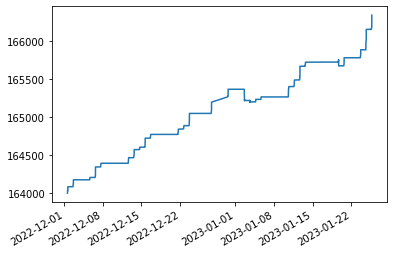

In [19]:
bal_agg_df = pd.concat([*dfs], axis=1).fillna(method='ffill').iloc[1:]
bal_agg_df["TOTAL"] = bal_agg_df.sum(axis = 1)
bal_agg_df["TOTAL"].plot()

In [20]:
days=(bal_agg_df.index[-1]-bal_agg_df.index[0]).days
roi = bal_agg_df.iloc[-1,-1]/bal_agg_df.iloc[0,-1]-1
print(f"Total ROI: {roi:.3%}")
print(f"Over: {days} days")
print(f"Annualized ROI: {(roi+1)**(365/days)-1:.3%}")

Total ROI: 1.428%
Over: 55 days
Annualized ROI: 9.868%


In [42]:
display(bal_agg_df)

,Ryanair@trader_0,Ryanair@trader_1,Ryanair@trader_2,Ryanair@trader_3,Tesla@trader_0,Tesla@trader_1,Tesla@trader_2,Tesla@trader_3,Netflix@trader_0,Netflix@trader_1,...,Spotify@trader_3,Doordash@trader_0,Doordash@trader_1,Doordash@trader_2,Doordash@trader_3,Deutsche Bank@trader_0,Deutsche Bank@trader_1,Deutsche Bank@trader_2,Deutsche Bank@trader_3,TOTAL
2023-01-25 16:30:00+00:00,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,...,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,165897.190372
2023-01-25 16:30:00+00:00,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,...,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,165897.190372
2023-01-25 16:30:00+00:00,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,...,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,1011.568234,165897.190372


In [31]:
all_tickers = arb_df.dropna()